In [1]:
import torch
import torch.optim as optim
import torch.utils.data as data
from tqdm import tqdm
import torch.nn as nn
import torchvision.transforms as T
from torch.utils.data import Dataset,DataLoader

import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import random 
from collections import Counter
from auglib import TrivialAugment
from torchvision.datasets import MNIST,CIFAR10,CIFAR100
from torchvision.datasets import ImageFolder


C:\Users\admin\anaconda3\envs\ocr_engine\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: Could not find module 'C:\Users\admin\anaconda3\envs\ocr_engine\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


In [2]:
cub_data_dir = 'D:/Dataset/CUB/CUB_200_2011/images/'
tiny_data_dir='D:/Dataset/tiny-imagenet-200/'



In [3]:
import math
import torch.nn as nn
from kernel import CannyFilter,get_thin_kernels,get_gaussian_kernel

In [4]:
import ssl

#transform=T.Compose([T.ToTensor(),T.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])
#transform=T.Compose([T.AutoAugment()])
train_transform=T.Compose([#T.Resize(32),
                           #T.RandomResizedCrop(64),
                           T.RandomHorizontalFlip(),
                           T.ToTensor(),T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

valid_transform=T.Compose([T.ToTensor(),T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])
#train_ds=ImageFolder(os.path.join(tiny_data_dir,'train'),transform=train_transform)
#valid_ds=ImageFolder(os.path.join(tiny_data_dir,'val_'),transform=valid_transform)
                                        
#train_set=MiniImagenet(root="D:/Dataset/Mini-ImageNet",mode='train',transform=transform)
torch.manual_seed(1)
#train_set, val_set = torch.utils.data.random_split(train_set, [30000, 8400])

#ssl._create_default_https_context = ssl._create_unverified_context
train_ds=CIFAR100(root="data",train=True,transform=train_transform,download=False)
valid_ds=CIFAR100(root="data",train=False,transform=valid_transform,download=False)

In [5]:
train_ds[0][0].shape

torch.Size([3, 32, 32])

In [6]:
torch.stack([train_ds[x][0] for x in range(4)]).shape

torch.Size([4, 3, 32, 32])

In [7]:
import torchvision

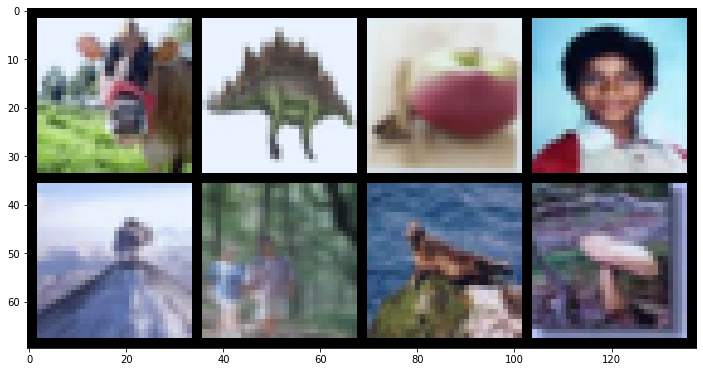

In [8]:
grid_img = torchvision.utils.make_grid(torch.cat([torch.stack([train_ds[x][0] for x in range(4)]),
                                                  torch.stack([valid_ds[x][0] for x in range(4)])]).detach(), nrow=4,normalize=True)
#gt=[label_name[x.long()] for x in LABELS]
plt.figure(figsize=(12,8))
#plt.title(gt)
plt.imshow(grid_img.permute(1, 2, 0))

In [9]:
train_dl = torch.utils.data.DataLoader(dataset=train_ds,
                                          batch_size=100,
                                          shuffle=True,
                                          drop_last=True)
valid_dl = torch.utils.data.DataLoader(dataset=valid_ds,
                                          batch_size=100,
                                          shuffle=False,
                                          drop_last=True)

## MixFreq

In [10]:
def mix_freq(img,label,b_kernel,e_kernel,lamB=0.5,lamE=0.5):
    with torch.no_grad():
        blured_img=b_kernel(img)
       # edged_img=img-blured_img
        edged_img=e_kernel(img)[1].expand(-1,3,-1,-1)
        idx = torch.randperm(blured_img.shape[0])
        edged_img=edged_img[idx]
        y_b,y_e=label,label[idx]
        mixed_img=lamB*blured_img+lamE*edged_img#+0.2*img
    return mixed_img,y_b,y_e,lamB,lamE,idx
    
def mix_freq_classic(img,label,b_kernel,alpha=1):
    lam=np.random.beta(alpha,alpha)
    with torch.no_grad():
        edged_img=img-b_kernel(img)
    idx = torch.randperm(img.shape[0])
    edged_img=edged_img[idx]
    y_a,y_e=label,label[idx]
    mixed_img=lam*img+(1-lam)*edged_img
    ##+0.2*img
    return mixed_img,y_a,y_e,lam

    return mixed_img,y_b,y_e
def mixfreq_criterion(criterion, pred, y_a, y_b):
    return  criterion(pred, y_a) + criterion(pred, y_b)

## Cutmix

In [11]:
def cutmix(x, y, alpha=1.0, use_cuda=True):    
    with torch.no_grad():
        lam = np.random.beta(alpha, alpha)
        if use_cuda:
            rand_index = torch.randperm(x.size()[0]).cuda()
        else:
            rand_index = torch.randperm(x.size()[0])
        x_copy=x.clone()

        target_a = y
        target_b = y[rand_index]
        bbx1, bby1, bbx2, bby2 = rand_bbox(x_copy.size(), lam)
        x_copy[:, :, bbx1:bbx2, bby1:bby2] = x_copy[rand_index, :, bbx1:bbx2, bby1:bby2]
        # adjust lambda to exactly match pixel ratio
        lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (x.size()[-1] * x.size()[-2]))
    return x_copy, target_a, target_b, lam,rand_index
    
    
def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int16(W * cut_rat)
    cut_h = np.int16(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2
def cutmix_criterion(criterion, pred, y_a, y_b, lam):
    return criterion(pred, y_a) * lam + criterion(pred, y_b) * (1. - lam)

## Mixup

In [12]:

def mixup_data(x, y, alpha=1.0, use_cuda=True):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    if use_cuda:
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam,index


def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)





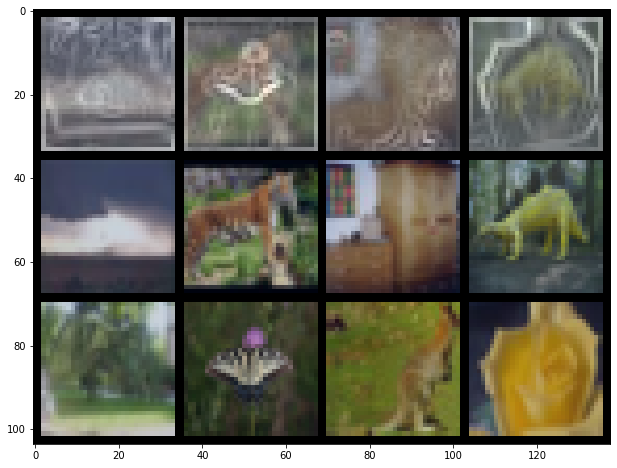

In [13]:
import torchvision
img,label=next(iter(train_dl))
blur_kernel=CannyFilter(k_gaussian=3,k_sobel=3,blur=True)
edge_kernel=CannyFilter(k_gaussian=1,k_sobel=3,blur=False)
mixed_img,_,_,_,_,idx=mix_freq(img,label,blur_kernel,edge_kernel,lamB=0.5,lamE=0.5)
grid_img = torchvision.utils.make_grid(torch.cat([mixed_img[0:4],img[0:4],img[idx[0:4]]]).detach(), nrow=4,normalize=True)
#gt=[label_name[x.long()] for x in LABELS]
plt.figure(figsize=(12,8))
#plt.title(gt)
plt.imshow(grid_img.permute(1, 2, 0))

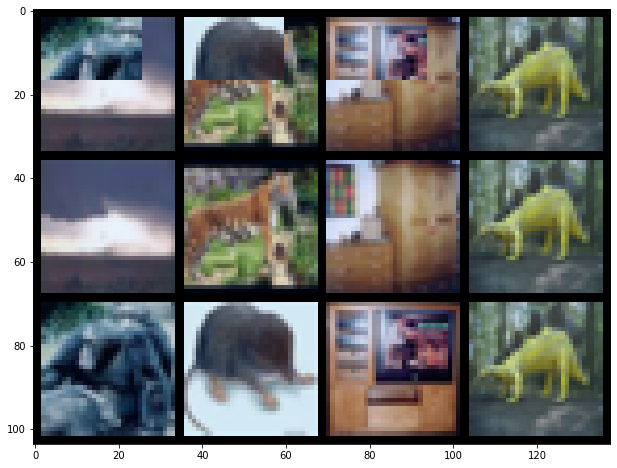

In [14]:
cut_mix,_,_,_,idx=cutmix(img,label)
grid_img = torchvision.utils.make_grid(torch.cat([cut_mix[0:4],img[0:4],img[idx[0:4]]]).detach(), nrow=4,normalize=True)
#gt=[label_name[x.long()] for x in LABELS]
plt.figure(figsize=(12,8))
#plt.title(gt)
plt.imshow(grid_img.permute(1, 2, 0))

In [15]:
# mixup,_,_,_,idx=mixup_data(img,label)
# grid_img = torchvision.utils.make_grid(torch.cat([mixup[0:4],img[0:4],img[idx[0:4]]]).detach(), nrow=4,normalize=True)
# #gt=[label_name[x.long()] for x in LABELS]
# plt.figure(figsize=(12,8))
# #plt.title(gt)
# plt.imshow(grid_img.permute(1, 2, 0))

In [16]:
import wandb

In [17]:
import torchvision.models as models
from torchvision.models import AlexNet
# blur_kernel=CannyFilter(k_gaussian=3,k_sobel=3,blur=True)
# edge_kernel=CannyFilter(k_gaussian=1,k_sobel=3,blur=False)

#optimizer = optim.Adam(model.parameters(), lr=0.005)
device='cuda'

In [18]:
#from collections import Counter
#Counter(full_dataset.targets)

In [ ]:
# blur_kernel=CannyFilter(k_gaussian=3,k_sobel=3,blur=True,use_cuda=True)
# blur_kernel.to(device)
# edge_kernel=CannyFilter(k_gaussian=1,k_sobel=3,blur=False,use_cuda=True)
# edge_kernel.to(device)
model = models.resnet18(pretrained=False)
model.fc=nn.Linear(512,100)
#model=AlexNet(num_classes=200)

criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(model.parameters(), lr=0.2, momentum=0.9,
#                      weight_decay=1e-4)
optimizer = optim.Adam(model.parameters(), lr=0.05)

model.to(device)

wandb.init(project="Augmentation_Strategy_CIFAR100")
wandb.run.name = "Base_ResNet18_0.005_Pretrained"
wandb.run.save()
max_val_accuracy=0
for epoch in tqdm(range(300),leave=False):
    print(f'Epochs : {epoch+1}')
    model.train()
    avg_train_loss=0
    correct=0
    total=0
    for batch_idx,(img,label) in tqdm(enumerate(train_dl),leave=True):
#         #Zero_grad_Optimizer
        optimizer.zero_grad()
        img=img.to(device)
        label=label.to(device).long()
#         if epoch in list(np.arange(0,20,1,dtype=int))+list(np.arange(40,60,1,dtype=int))+list(np.arange(80,100,1,dtype=int)):
#         #if epoch in list(np.arange(0,60,1,dtype=int)):
#             train_auged=True
#         else:
#             train_auged=False
            
#         if train_auged:
#             img,labelA,labelB,_,_,_=mix_freq(img,label,b_kernel=blur_kernel,e_kernel=edge_kernel)
            
#             img,labelA,labelB,lam,idx=cutmix(img,label)
#             output=model(img)
#             loss=mixfreq_criterion(criterion, output, labelA, labelB)
#             #loss=mcut_mix_criterion(criterion, output, labelA, labelB, lam)
#             #Measure Loss
#             loss.backward()
#         else:
        output=model(img)
        loss=criterion(output,label)
        loss.backward()
        #Update Parameters
        optimizer.step()
        avg_train_loss+=loss.item()
        if batch_idx % 50==0:
            wandb.log({
                "Train Loss": avg_train_loss/(batch_idx+1)})
    model.eval()
    valid_loss=0
    correct=0
    total=0
    with torch.no_grad():
        for batch_idx,(img,label) in enumerate(valid_dl):

            img=img.to(device)
            label=label.to(device).long()

            output=model(img)
            #Measure Loss
            loss=criterion(output,label)
            valid_loss+=loss.item()

            _, predicted = torch.max(output.data, 1)
            total+=label.shape[0]
            correct += (predicted == label).sum().item()
    avg_valid_loss=valid_loss/(len(valid_dl))
    wandb.log({
        "epoch": epoch,
        "Val Accuracy": correct/total,
        "Val Loss": avg_valid_loss})
    if (correct/total)>max_val_accuracy:
        max_val_accuracy=correct/total
        print('Validation Result is better, saving the new model')
        torch.save(model.state_dict(),"models/base_alter_tiny_pretrained.h")


wandb: Currently logged in as: hslrock (use `wandb login --relogin` to force relogin)


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.
  0%|                                                                                          | 0/300 [00:00<?, ?it/s]

Epochs : 1



0it [00:00, ?it/s]
1it [00:04,  4.20s/it]
3it [00:04,  1.14s/it]
5it [00:04,  1.71it/s]
7it [00:04,  2.75it/s]
9it [00:04,  3.99it/s]
11it [00:04,  5.46it/s]
13it [00:04,  6.82it/s]
15it [00:05,  8.47it/s]
17it [00:05,  9.97it/s]
19it [00:05, 11.10it/s]
21it [00:05, 12.46it/s]
23it [00:05, 13.10it/s]
25it [00:05, 13.92it/s]
27it [00:05, 14.85it/s]
29it [00:05, 15.22it/s]
31it [00:06, 15.82it/s]
33it [00:06, 16.35it/s]
35it [00:06, 16.65it/s]
37it [00:06, 16.87it/s]
39it [00:06, 17.07it/s]
41it [00:06, 15.67it/s]
43it [00:06, 16.27it/s]
45it [00:06, 16.76it/s]
47it [00:07, 15.96it/s]
49it [00:07, 15.08it/s]
51it [00:07, 15.17it/s]
53it [00:07, 15.74it/s]
55it [00:07, 16.01it/s]
57it [00:07, 15.71it/s]
59it [00:07, 15.91it/s]
61it [00:07, 16.29it/s]
63it [00:08, 15.53it/s]
65it [00:08, 16.05it/s]
67it [00:08, 16.47it/s]
69it [00:08, 16.61it/s]
71it [00:08, 16.84it/s]
73it [00:08, 16.92it/s]
75it [00:08, 16.09it/s]
77it [00:08, 16.55it/s]
79it [00:09, 16.26it/s]
81it [00:09, 16.55it/s]
8

Validation Result is better, saving the new model
Epochs : 2



0it [00:00, ?it/s]
2it [00:00, 14.31it/s]
4it [00:00, 15.83it/s]
6it [00:00, 16.57it/s]
8it [00:00, 16.89it/s]
10it [00:00, 17.07it/s]
12it [00:00, 17.23it/s]
14it [00:00, 17.34it/s]
16it [00:00, 17.31it/s]
18it [00:01, 17.58it/s]
20it [00:01, 17.57it/s]
22it [00:01, 17.52it/s]
24it [00:01, 14.94it/s]
26it [00:01, 15.36it/s]
28it [00:01, 16.08it/s]
30it [00:01, 16.37it/s]
32it [00:01, 16.88it/s]
34it [00:02, 17.12it/s]
36it [00:02, 15.88it/s]
38it [00:02, 16.15it/s]
40it [00:02, 16.63it/s]
42it [00:02, 16.73it/s]
44it [00:02, 15.69it/s]
46it [00:02, 15.97it/s]
48it [00:02, 16.54it/s]
50it [00:03, 16.54it/s]
52it [00:03, 16.78it/s]
54it [00:03, 16.97it/s]
56it [00:03, 15.37it/s]
58it [00:03, 15.44it/s]
60it [00:03, 16.22it/s]
62it [00:03, 15.55it/s]
64it [00:03, 15.58it/s]
66it [00:04, 15.82it/s]
68it [00:04, 16.46it/s]
70it [00:04, 16.90it/s]
72it [00:04, 16.71it/s]
74it [00:04, 17.00it/s]
76it [00:04, 17.16it/s]
78it [00:04, 17.23it/s]
80it [00:04, 17.24it/s]
82it [00:04, 16.31it/s]


Validation Result is better, saving the new model
Epochs : 3



0it [00:00, ?it/s]
2it [00:00, 12.43it/s]
4it [00:00, 14.37it/s]
6it [00:00, 15.56it/s]
8it [00:00, 15.83it/s]
10it [00:00, 16.08it/s]
12it [00:00, 16.74it/s]
14it [00:00, 17.11it/s]
16it [00:00, 17.20it/s]
18it [00:01, 17.08it/s]
20it [00:01, 17.27it/s]
22it [00:01, 17.49it/s]
24it [00:01, 17.65it/s]
26it [00:01, 17.24it/s]
28it [00:01, 17.34it/s]
30it [00:01, 16.87it/s]
32it [00:01, 17.25it/s]
34it [00:02, 16.99it/s]
36it [00:02, 17.33it/s]
38it [00:02, 17.49it/s]
40it [00:02, 17.42it/s]
42it [00:02, 17.46it/s]
44it [00:02, 17.49it/s]
46it [00:02, 17.60it/s]
48it [00:02, 17.68it/s]
50it [00:02, 17.64it/s]
52it [00:03, 17.48it/s]
54it [00:03, 17.23it/s]
56it [00:03, 16.67it/s]
58it [00:03, 16.97it/s]
60it [00:03, 17.32it/s]
62it [00:03, 17.44it/s]
64it [00:03, 17.52it/s]
66it [00:03, 17.67it/s]
68it [00:03, 17.92it/s]
70it [00:04, 16.95it/s]
72it [00:04, 15.64it/s]
74it [00:04, 16.29it/s]
76it [00:04, 16.16it/s]
78it [00:04, 15.74it/s]
80it [00:04, 15.10it/s]
82it [00:04, 15.08it/s]


Validation Result is better, saving the new model
Epochs : 4



0it [00:00, ?it/s]
2it [00:00, 11.57it/s]
4it [00:00, 13.82it/s]
6it [00:00, 14.45it/s]
8it [00:00, 15.41it/s]
10it [00:00, 15.84it/s]
12it [00:00, 15.82it/s]
14it [00:00, 16.13it/s]
16it [00:01, 16.51it/s]
18it [00:01, 16.69it/s]
20it [00:01, 16.99it/s]
22it [00:01, 16.55it/s]
24it [00:01, 15.46it/s]
26it [00:01, 15.70it/s]
28it [00:01, 16.06it/s]
30it [00:01, 15.45it/s]
32it [00:02, 14.85it/s]
34it [00:02, 15.57it/s]
36it [00:02, 16.16it/s]
38it [00:02, 16.51it/s]
40it [00:02, 16.73it/s]
42it [00:02, 16.88it/s]
44it [00:02, 17.21it/s]
46it [00:02, 17.36it/s]
48it [00:02, 17.02it/s]
50it [00:03, 17.08it/s]
52it [00:03, 17.13it/s]
54it [00:03, 16.96it/s]
56it [00:03, 17.22it/s]
58it [00:03, 17.28it/s]
60it [00:03, 17.09it/s]
62it [00:03, 17.05it/s]
64it [00:03, 16.98it/s]
66it [00:04, 17.06it/s]
68it [00:04, 17.21it/s]
70it [00:04, 17.31it/s]
72it [00:04, 17.43it/s]
74it [00:04, 17.65it/s]
76it [00:04, 17.04it/s]
78it [00:04, 17.19it/s]
80it [00:04, 17.25it/s]
82it [00:04, 17.30it/s]


Validation Result is better, saving the new model
Epochs : 5



0it [00:00, ?it/s]
2it [00:00, 13.71it/s]
4it [00:00, 15.04it/s]
6it [00:00, 16.09it/s]
8it [00:00, 16.64it/s]
10it [00:00, 16.85it/s]
12it [00:00, 16.99it/s]
14it [00:00, 16.98it/s]
16it [00:00, 16.97it/s]
18it [00:01, 16.92it/s]
20it [00:01, 17.07it/s]
22it [00:01, 16.52it/s]
24it [00:01, 16.78it/s]
26it [00:01, 16.50it/s]
28it [00:01, 16.11it/s]
30it [00:01, 16.64it/s]
32it [00:01, 16.91it/s]
34it [00:02, 15.84it/s]
36it [00:02, 15.70it/s]
38it [00:02, 15.75it/s]
40it [00:02, 16.18it/s]
42it [00:02, 16.57it/s]
44it [00:02, 16.98it/s]
46it [00:02, 17.19it/s]
48it [00:02, 17.44it/s]
50it [00:03, 17.52it/s]
52it [00:03, 17.57it/s]
54it [00:03, 16.94it/s]
56it [00:03, 17.17it/s]
58it [00:03, 17.51it/s]
60it [00:03, 17.61it/s]
62it [00:03, 16.35it/s]
64it [00:03, 16.77it/s]
66it [00:03, 17.14it/s]
68it [00:04, 17.30it/s]
70it [00:04, 16.81it/s]
72it [00:04, 17.20it/s]
74it [00:04, 17.17it/s]
76it [00:04, 17.21it/s]
78it [00:04, 17.40it/s]
80it [00:04, 17.40it/s]
82it [00:04, 17.31it/s]


Validation Result is better, saving the new model
Epochs : 6



0it [00:00, ?it/s]
1it [00:00,  9.53it/s]
3it [00:00, 13.54it/s]
5it [00:00, 15.34it/s]
7it [00:00, 15.37it/s]
9it [00:00, 16.18it/s]
11it [00:00, 16.40it/s]
13it [00:00, 16.67it/s]
15it [00:00, 14.70it/s]
17it [00:01, 15.24it/s]
19it [00:01, 15.69it/s]
21it [00:01, 16.14it/s]
23it [00:01, 16.38it/s]
25it [00:01, 16.64it/s]
27it [00:01, 16.82it/s]
29it [00:01, 16.28it/s]
31it [00:01, 16.65it/s]
33it [00:02, 16.37it/s]
35it [00:02, 16.71it/s]
37it [00:02, 16.87it/s]
39it [00:02, 17.02it/s]
41it [00:02, 17.05it/s]
43it [00:02, 17.20it/s]
45it [00:02, 17.26it/s]
47it [00:02, 17.44it/s]
49it [00:02, 17.56it/s]
51it [00:03, 17.65it/s]
53it [00:03, 17.72it/s]
55it [00:03, 17.81it/s]
57it [00:03, 17.78it/s]
59it [00:03, 17.90it/s]
61it [00:03, 17.80it/s]
63it [00:03, 17.31it/s]
65it [00:03, 16.36it/s]
67it [00:04, 16.78it/s]
69it [00:04, 15.84it/s]
71it [00:04, 15.93it/s]
73it [00:04, 16.54it/s]
75it [00:04, 16.58it/s]
77it [00:04, 16.61it/s]
79it [00:04, 16.89it/s]
81it [00:04, 17.04it/s]
8

Validation Result is better, saving the new model
Epochs : 7



0it [00:00, ?it/s]
1it [00:00,  9.80it/s]
3it [00:00, 12.77it/s]
5it [00:00, 14.80it/s]
7it [00:00, 15.59it/s]
9it [00:00, 15.75it/s]
11it [00:00, 16.20it/s]
13it [00:00, 15.97it/s]
15it [00:00, 16.49it/s]
17it [00:01, 16.55it/s]
19it [00:01, 16.94it/s]
21it [00:01, 16.94it/s]
23it [00:01, 17.12it/s]
25it [00:01, 17.21it/s]
27it [00:01, 16.58it/s]
29it [00:01, 16.32it/s]
31it [00:01, 16.84it/s]
33it [00:02, 16.92it/s]
35it [00:02, 17.06it/s]
37it [00:02, 17.25it/s]
39it [00:02, 17.48it/s]
41it [00:02, 17.59it/s]
43it [00:02, 17.63it/s]
45it [00:02, 17.84it/s]
47it [00:02, 17.80it/s]
49it [00:02, 17.78it/s]
51it [00:03, 17.71it/s]
53it [00:03, 17.21it/s]
55it [00:03, 17.22it/s]
57it [00:03, 17.10it/s]
59it [00:03, 17.32it/s]
61it [00:03, 17.47it/s]
63it [00:03, 17.68it/s]
65it [00:03, 17.60it/s]
67it [00:03, 17.63it/s]
69it [00:04, 17.70it/s]
71it [00:04, 17.67it/s]
73it [00:04, 17.73it/s]
75it [00:04, 17.68it/s]
77it [00:04, 17.64it/s]
79it [00:04, 17.29it/s]
81it [00:04, 16.97it/s]
8

Epochs : 8



0it [00:00, ?it/s]
2it [00:00, 12.59it/s]
4it [00:00, 14.64it/s]
6it [00:00, 15.67it/s]
8it [00:00, 16.31it/s]
10it [00:00, 16.79it/s]
12it [00:00, 16.94it/s]
14it [00:00, 16.95it/s]
16it [00:00, 17.09it/s]
18it [00:01, 17.33it/s]
20it [00:01, 16.52it/s]
22it [00:01, 16.73it/s]
24it [00:01, 16.89it/s]
26it [00:01, 17.04it/s]
28it [00:01, 17.15it/s]
30it [00:01, 15.75it/s]
32it [00:01, 16.02it/s]
34it [00:02, 16.45it/s]
36it [00:02, 16.48it/s]
38it [00:02, 16.66it/s]
40it [00:02, 16.88it/s]
42it [00:02, 16.94it/s]
44it [00:02, 15.25it/s]
46it [00:02, 15.58it/s]
48it [00:02, 15.31it/s]
50it [00:03, 15.16it/s]
52it [00:03, 15.51it/s]
54it [00:03, 16.00it/s]
56it [00:03, 16.39it/s]
58it [00:03, 16.36it/s]
60it [00:03, 16.54it/s]
62it [00:03, 16.54it/s]
64it [00:03, 16.58it/s]
66it [00:04, 16.91it/s]
68it [00:04, 17.01it/s]
70it [00:04, 16.53it/s]
72it [00:04, 16.29it/s]
74it [00:04, 13.97it/s]
76it [00:04, 14.85it/s]
78it [00:04, 15.42it/s]
80it [00:04, 16.00it/s]
82it [00:05, 16.01it/s]


Validation Result is better, saving the new model
Epochs : 9



0it [00:00, ?it/s]
2it [00:00, 13.52it/s]
4it [00:00, 14.82it/s]
6it [00:00, 15.29it/s]
8it [00:00, 15.85it/s]
10it [00:00, 16.38it/s]
12it [00:00, 16.63it/s]
14it [00:00, 16.56it/s]
16it [00:00, 16.77it/s]
18it [00:01, 16.07it/s]
20it [00:01, 16.29it/s]
22it [00:01, 16.00it/s]
24it [00:01, 16.53it/s]
26it [00:01, 16.21it/s]
28it [00:01, 16.15it/s]
30it [00:01, 15.91it/s]
32it [00:01, 16.46it/s]
34it [00:02, 16.69it/s]
36it [00:02, 16.69it/s]
38it [00:02, 16.94it/s]
40it [00:02, 16.53it/s]
42it [00:02, 16.50it/s]
44it [00:02, 16.23it/s]
46it [00:02, 15.27it/s]
48it [00:02, 15.74it/s]
50it [00:03, 15.04it/s]
52it [00:03, 14.94it/s]
54it [00:03, 15.21it/s]
56it [00:03, 15.37it/s]
58it [00:03, 14.44it/s]
60it [00:03, 15.15it/s]
62it [00:03, 15.09it/s]
64it [00:04, 15.60it/s]
66it [00:04, 14.49it/s]
68it [00:04, 14.40it/s]
70it [00:04, 14.10it/s]
72it [00:04, 13.96it/s]
74it [00:04, 14.18it/s]
76it [00:04, 14.85it/s]
78it [00:05, 14.36it/s]
80it [00:05, 14.37it/s]
82it [00:05, 13.67it/s]


Epochs : 10



0it [00:00, ?it/s]
1it [00:00,  9.53it/s]
3it [00:00, 12.96it/s]
5it [00:00, 14.80it/s]
7it [00:00, 14.81it/s]
9it [00:00, 15.74it/s]
11it [00:00, 16.28it/s]
13it [00:00, 16.73it/s]
15it [00:00, 17.04it/s]
17it [00:01, 17.10it/s]
19it [00:01, 17.24it/s]
21it [00:01, 17.43it/s]
23it [00:01, 17.47it/s]
25it [00:01, 17.00it/s]
27it [00:01, 17.25it/s]
29it [00:01, 17.48it/s]
31it [00:01, 17.23it/s]
33it [00:01, 17.46it/s]
35it [00:02, 17.35it/s]
37it [00:02, 17.19it/s]
39it [00:02, 17.34it/s]
41it [00:02, 16.75it/s]
43it [00:02, 17.03it/s]
45it [00:02, 17.27it/s]
47it [00:02, 17.40it/s]
49it [00:02, 17.31it/s]
51it [00:03, 17.52it/s]
53it [00:03, 17.62it/s]
55it [00:03, 17.70it/s]
57it [00:03, 17.33it/s]
59it [00:03, 17.00it/s]
61it [00:03, 16.86it/s]
63it [00:03, 16.03it/s]
65it [00:03, 15.84it/s]
67it [00:03, 16.27it/s]
69it [00:04, 16.23it/s]
71it [00:04, 15.31it/s]
73it [00:04, 15.55it/s]
75it [00:04, 15.99it/s]
77it [00:04, 16.39it/s]
79it [00:04, 16.72it/s]
81it [00:04, 16.96it/s]
8

Validation Result is better, saving the new model
Epochs : 11



0it [00:00, ?it/s]
2it [00:00, 14.51it/s]
4it [00:00, 15.15it/s]
6it [00:00, 15.10it/s]
8it [00:00, 15.21it/s]
10it [00:00, 15.20it/s]
12it [00:00, 15.38it/s]
14it [00:00, 15.86it/s]
16it [00:01, 15.87it/s]
18it [00:01, 16.32it/s]
20it [00:01, 16.51it/s]
22it [00:01, 16.82it/s]
24it [00:01, 16.82it/s]
26it [00:01, 17.03it/s]
28it [00:01, 17.10it/s]
30it [00:01, 17.10it/s]
32it [00:01, 17.19it/s]
34it [00:02, 17.26it/s]
36it [00:02, 17.03it/s]
38it [00:02, 17.10it/s]
40it [00:02, 16.15it/s]
42it [00:02, 15.36it/s]
44it [00:02, 14.29it/s]
46it [00:02, 14.89it/s]
48it [00:03, 15.32it/s]
50it [00:03, 15.78it/s]
52it [00:03, 16.23it/s]
54it [00:03, 15.27it/s]
56it [00:03, 15.71it/s]
58it [00:03, 16.22it/s]
60it [00:03, 16.60it/s]
62it [00:03, 16.92it/s]
64it [00:03, 17.19it/s]
66it [00:04, 17.30it/s]
68it [00:04, 17.06it/s]
70it [00:04, 16.86it/s]
72it [00:04, 17.11it/s]
74it [00:04, 17.33it/s]
76it [00:04, 17.30it/s]
78it [00:04, 17.47it/s]
80it [00:04, 15.43it/s]
82it [00:05, 15.67it/s]


Epochs : 12



0it [00:00, ?it/s]
2it [00:00, 13.99it/s]
4it [00:00, 14.91it/s]
6it [00:00, 15.03it/s]
8it [00:00, 15.45it/s]
10it [00:00, 14.73it/s]
12it [00:00, 14.76it/s]
14it [00:00, 15.11it/s]
16it [00:01, 15.77it/s]
18it [00:01, 15.73it/s]
20it [00:01, 14.94it/s]
22it [00:01, 15.62it/s]
24it [00:01, 16.00it/s]
26it [00:01, 16.36it/s]
28it [00:01, 16.58it/s]
30it [00:01, 16.86it/s]
32it [00:02, 17.02it/s]
34it [00:02, 17.18it/s]
36it [00:02, 16.16it/s]
38it [00:02, 16.68it/s]
40it [00:02, 16.11it/s]
42it [00:02, 16.48it/s]
44it [00:02, 16.33it/s]
46it [00:02, 15.48it/s]
48it [00:03, 16.05it/s]
50it [00:03, 16.56it/s]
52it [00:03, 16.93it/s]
54it [00:03, 17.11it/s]
56it [00:03, 17.24it/s]
58it [00:03, 17.34it/s]
60it [00:03, 17.49it/s]
62it [00:03, 16.60it/s]
64it [00:03, 17.00it/s]
66it [00:04, 17.12it/s]
68it [00:04, 17.20it/s]
70it [00:04, 17.35it/s]
72it [00:04, 17.50it/s]
74it [00:04, 17.62it/s]
76it [00:04, 17.55it/s]
78it [00:04, 17.55it/s]
80it [00:04, 17.10it/s]
82it [00:04, 17.06it/s]


Validation Result is better, saving the new model
Epochs : 13



0it [00:00, ?it/s]
2it [00:00, 13.45it/s]
4it [00:00, 14.85it/s]
6it [00:00, 15.45it/s]
8it [00:00, 15.96it/s]
10it [00:00, 16.45it/s]
12it [00:00, 16.86it/s]
14it [00:00, 16.57it/s]
16it [00:00, 16.87it/s]
18it [00:01, 16.67it/s]
20it [00:01, 15.56it/s]
22it [00:01, 16.12it/s]
24it [00:01, 16.12it/s]
26it [00:01, 15.63it/s]
28it [00:01, 15.20it/s]
30it [00:01, 15.29it/s]
32it [00:02, 15.25it/s]
34it [00:02, 15.84it/s]
36it [00:02, 16.01it/s]
38it [00:02, 16.44it/s]
40it [00:02, 15.84it/s]
42it [00:02, 15.71it/s]
44it [00:02, 14.78it/s]
46it [00:02, 14.96it/s]
48it [00:03, 15.62it/s]
50it [00:03, 16.07it/s]
52it [00:03, 16.13it/s]
54it [00:03, 16.53it/s]
56it [00:03, 16.70it/s]
58it [00:03, 16.99it/s]
60it [00:03, 17.11it/s]
62it [00:03, 16.60it/s]
64it [00:03, 16.67it/s]
66it [00:04, 16.76it/s]
68it [00:04, 16.48it/s]
70it [00:04, 15.40it/s]
72it [00:04, 15.54it/s]
74it [00:04, 15.39it/s]
76it [00:04, 15.83it/s]
78it [00:04, 15.70it/s]
80it [00:05, 15.83it/s]
82it [00:05, 15.92it/s]


Validation Result is better, saving the new model
Epochs : 14



0it [00:00, ?it/s]
2it [00:00, 14.72it/s]
4it [00:00, 15.45it/s]
6it [00:00, 14.95it/s]
8it [00:00, 14.74it/s]
10it [00:00, 15.17it/s]
12it [00:00, 15.78it/s]
14it [00:00, 16.14it/s]
16it [00:01, 16.44it/s]
18it [00:01, 16.38it/s]
20it [00:01, 16.73it/s]
22it [00:01, 17.02it/s]
24it [00:01, 17.04it/s]
26it [00:01, 17.24it/s]
28it [00:01, 17.33it/s]
30it [00:01, 17.49it/s]
32it [00:01, 16.76it/s]
34it [00:02, 16.91it/s]
36it [00:02, 17.01it/s]
38it [00:02, 17.17it/s]
40it [00:02, 17.11it/s]
42it [00:02, 16.85it/s]
44it [00:02, 17.23it/s]
46it [00:02, 17.46it/s]
48it [00:02, 17.58it/s]
50it [00:02, 17.62it/s]
52it [00:03, 16.51it/s]
54it [00:03, 16.57it/s]
56it [00:03, 16.94it/s]
58it [00:03, 16.40it/s]
60it [00:03, 16.86it/s]
62it [00:03, 17.15it/s]
64it [00:03, 17.36it/s]
66it [00:03, 17.46it/s]
68it [00:04, 17.54it/s]
70it [00:04, 17.54it/s]
72it [00:04, 17.59it/s]
74it [00:04, 17.67it/s]
76it [00:04, 17.23it/s]
78it [00:04, 16.55it/s]
80it [00:04, 16.59it/s]
82it [00:04, 17.08it/s]


Epochs : 15



0it [00:00, ?it/s]
2it [00:00, 11.84it/s]
4it [00:00, 14.29it/s]
6it [00:00, 14.29it/s]
8it [00:00, 14.50it/s]
10it [00:00, 14.97it/s]
12it [00:00, 14.48it/s]
14it [00:00, 14.76it/s]
16it [00:01, 15.32it/s]
18it [00:01, 16.00it/s]
20it [00:01, 16.32it/s]
22it [00:01, 16.64it/s]
24it [00:01, 16.82it/s]
26it [00:01, 17.04it/s]
28it [00:01, 16.31it/s]
30it [00:01, 15.98it/s]
32it [00:02, 16.18it/s]
34it [00:02, 16.61it/s]
36it [00:02, 16.97it/s]
38it [00:02, 17.19it/s]
40it [00:02, 16.99it/s]
42it [00:02, 15.85it/s]
44it [00:02, 16.21it/s]
46it [00:02, 16.19it/s]
48it [00:03, 16.62it/s]
50it [00:03, 16.89it/s]
52it [00:03, 17.04it/s]
54it [00:03, 17.18it/s]
56it [00:03, 17.38it/s]
58it [00:03, 16.73it/s]
60it [00:03, 17.06it/s]
62it [00:03, 17.29it/s]
64it [00:03, 17.42it/s]
66it [00:04, 17.37it/s]
68it [00:04, 17.56it/s]
70it [00:04, 17.60it/s]
72it [00:04, 17.41it/s]
74it [00:04, 17.54it/s]
76it [00:04, 17.64it/s]
78it [00:04, 17.71it/s]
80it [00:04, 17.07it/s]
82it [00:04, 17.35it/s]


Epochs : 16



0it [00:00, ?it/s]
2it [00:00, 12.91it/s]
4it [00:00, 15.02it/s]
6it [00:00, 15.62it/s]
8it [00:00, 15.39it/s]
10it [00:00, 15.39it/s]
12it [00:00, 15.81it/s]
14it [00:00, 16.17it/s]
16it [00:01, 16.26it/s]
18it [00:01, 15.22it/s]
20it [00:01, 15.68it/s]
22it [00:01, 16.21it/s]
24it [00:01, 16.60it/s]
26it [00:01, 16.88it/s]
28it [00:01, 16.95it/s]
30it [00:01, 16.37it/s]
32it [00:01, 16.54it/s]
34it [00:02, 16.76it/s]
36it [00:02, 16.86it/s]
38it [00:02, 16.97it/s]
40it [00:02, 17.10it/s]
42it [00:02, 17.10it/s]
44it [00:02, 17.32it/s]
46it [00:02, 17.40it/s]
48it [00:02, 15.79it/s]
50it [00:03, 15.97it/s]
52it [00:03, 16.50it/s]
54it [00:03, 16.84it/s]
56it [00:03, 17.09it/s]
58it [00:03, 17.32it/s]
60it [00:03, 17.30it/s]
62it [00:03, 16.35it/s]
64it [00:03, 16.70it/s]
66it [00:04, 16.99it/s]
68it [00:04, 17.20it/s]
70it [00:04, 17.40it/s]
72it [00:04, 16.33it/s]
74it [00:04, 16.64it/s]
76it [00:04, 17.03it/s]
78it [00:04, 16.84it/s]
80it [00:04, 16.62it/s]
82it [00:04, 16.89it/s]


Validation Result is better, saving the new model
Epochs : 17



0it [00:00, ?it/s]
2it [00:00, 14.93it/s]
4it [00:00, 15.69it/s]
6it [00:00, 15.97it/s]
8it [00:00, 16.19it/s]
10it [00:00, 16.46it/s]
12it [00:00, 16.63it/s]
14it [00:00, 16.16it/s]
16it [00:00, 16.07it/s]
18it [00:01, 15.51it/s]
20it [00:01, 15.97it/s]
22it [00:01, 16.46it/s]
24it [00:01, 16.08it/s]
26it [00:01, 16.50it/s]
28it [00:01, 15.84it/s]
30it [00:01, 16.32it/s]
32it [00:01, 16.76it/s]
34it [00:02, 15.71it/s]
36it [00:02, 16.15it/s]
38it [00:02, 16.46it/s]
40it [00:02, 16.86it/s]
42it [00:02, 17.11it/s]
44it [00:02, 17.28it/s]
46it [00:02, 17.36it/s]
48it [00:02, 17.11it/s]
50it [00:03, 16.64it/s]
52it [00:03, 15.42it/s]
54it [00:03, 16.04it/s]
56it [00:03, 16.55it/s]
58it [00:03, 17.01it/s]
60it [00:03, 16.83it/s]
62it [00:03, 17.04it/s]
64it [00:03, 16.15it/s]
66it [00:04, 15.88it/s]
68it [00:04, 15.95it/s]
70it [00:04, 16.32it/s]
72it [00:04, 16.67it/s]
74it [00:04, 16.31it/s]
76it [00:04, 16.42it/s]
78it [00:04, 16.29it/s]
80it [00:04, 16.61it/s]
82it [00:05, 16.59it/s]


Validation Result is better, saving the new model
Epochs : 18



0it [00:00, ?it/s]
2it [00:00, 15.51it/s]
4it [00:00, 15.87it/s]
6it [00:00, 16.29it/s]
8it [00:00, 16.66it/s]
10it [00:00, 17.02it/s]
12it [00:00, 17.26it/s]
14it [00:00, 16.83it/s]
16it [00:00, 15.54it/s]
18it [00:01, 14.95it/s]
20it [00:01, 15.56it/s]
22it [00:01, 15.77it/s]
24it [00:01, 16.36it/s]
26it [00:01, 16.66it/s]
28it [00:01, 16.88it/s]
30it [00:01, 17.21it/s]
32it [00:01, 17.22it/s]
34it [00:02, 17.51it/s]
36it [00:02, 17.52it/s]
38it [00:02, 17.62it/s]
40it [00:02, 17.60it/s]
42it [00:02, 17.63it/s]
44it [00:02, 17.70it/s]
46it [00:02, 17.61it/s]
48it [00:02, 17.59it/s]
50it [00:02, 17.44it/s]
52it [00:03, 17.57it/s]
54it [00:03, 17.61it/s]
56it [00:03, 17.55it/s]
58it [00:03, 17.55it/s]
60it [00:03, 16.93it/s]
62it [00:03, 17.16it/s]
64it [00:03, 17.45it/s]
66it [00:03, 17.48it/s]
68it [00:03, 17.37it/s]
70it [00:04, 16.60it/s]
72it [00:04, 16.10it/s]
74it [00:04, 16.55it/s]
76it [00:04, 15.06it/s]
78it [00:04, 15.62it/s]
80it [00:04, 16.12it/s]
82it [00:04, 16.52it/s]


Epochs : 19



0it [00:00, ?it/s]
2it [00:00, 10.26it/s]
4it [00:00, 13.21it/s]
6it [00:00, 14.74it/s]
8it [00:00, 15.47it/s]
10it [00:00, 15.86it/s]
12it [00:00, 16.26it/s]
14it [00:00, 15.76it/s]
16it [00:01, 16.38it/s]
18it [00:01, 16.60it/s]
20it [00:01, 17.06it/s]
22it [00:01, 17.53it/s]
24it [00:01, 17.49it/s]
26it [00:01, 17.79it/s]
28it [00:01, 17.91it/s]
30it [00:01, 16.44it/s]
32it [00:01, 16.51it/s]
34it [00:02, 16.98it/s]
36it [00:02, 17.19it/s]
38it [00:02, 15.85it/s]
40it [00:02, 15.68it/s]
42it [00:02, 15.70it/s]
44it [00:02, 15.90it/s]
46it [00:02, 16.25it/s]
48it [00:02, 16.66it/s]
50it [00:03, 17.09it/s]
52it [00:03, 17.12it/s]
54it [00:03, 17.34it/s]
56it [00:03, 17.58it/s]
58it [00:03, 17.62it/s]
60it [00:03, 17.79it/s]
62it [00:03, 17.67it/s]
64it [00:03, 17.68it/s]
66it [00:03, 17.14it/s]
68it [00:04, 17.36it/s]
70it [00:04, 17.58it/s]
72it [00:04, 17.71it/s]
74it [00:04, 17.80it/s]
76it [00:04, 17.82it/s]
78it [00:04, 17.60it/s]
80it [00:04, 17.77it/s]
82it [00:04, 17.14it/s]


Validation Result is better, saving the new model
Epochs : 20



0it [00:00, ?it/s]
2it [00:00, 13.71it/s]
4it [00:00, 14.59it/s]
6it [00:00, 14.28it/s]
8it [00:00, 14.70it/s]
10it [00:00, 14.82it/s]
12it [00:00, 15.62it/s]
14it [00:00, 15.91it/s]
16it [00:01, 16.02it/s]
18it [00:01, 14.73it/s]
20it [00:01, 14.66it/s]
22it [00:01, 14.48it/s]
24it [00:01, 15.37it/s]
26it [00:01, 15.94it/s]
28it [00:01, 15.30it/s]
30it [00:01, 15.01it/s]
32it [00:02, 15.19it/s]
34it [00:02, 15.50it/s]
36it [00:02, 14.82it/s]
38it [00:02, 14.40it/s]
40it [00:02, 13.81it/s]
42it [00:02, 14.82it/s]
44it [00:02, 15.58it/s]
46it [00:03, 16.16it/s]
48it [00:03, 15.62it/s]
50it [00:03, 16.04it/s]
52it [00:03, 14.66it/s]
54it [00:03, 15.18it/s]
56it [00:03, 14.70it/s]
58it [00:03, 15.07it/s]
60it [00:03, 14.90it/s]
62it [00:04, 15.47it/s]
64it [00:04, 15.73it/s]
66it [00:04, 16.32it/s]
68it [00:04, 16.67it/s]
70it [00:04, 16.38it/s]
72it [00:04, 16.35it/s]
74it [00:04, 16.29it/s]
76it [00:04, 15.21it/s]
78it [00:05, 15.26it/s]
80it [00:05, 15.37it/s]
82it [00:05, 15.59it/s]


Validation Result is better, saving the new model
Epochs : 21



0it [00:00, ?it/s]
2it [00:00, 13.15it/s]
4it [00:00, 15.22it/s]
6it [00:00, 13.63it/s]
8it [00:00, 14.36it/s]
10it [00:00, 14.37it/s]
12it [00:00, 15.00it/s]
14it [00:00, 14.80it/s]
16it [00:01, 14.74it/s]
18it [00:01, 14.57it/s]
20it [00:01, 14.20it/s]
22it [00:01, 14.45it/s]
24it [00:01, 14.96it/s]
26it [00:01, 15.40it/s]
28it [00:01, 15.73it/s]
30it [00:02, 15.02it/s]
32it [00:02, 15.17it/s]
34it [00:02, 14.63it/s]
36it [00:02, 14.22it/s]
38it [00:02, 14.49it/s]
40it [00:02, 15.22it/s]
42it [00:02, 15.34it/s]
44it [00:02, 15.25it/s]
46it [00:03, 15.55it/s]
48it [00:03, 14.40it/s]
50it [00:03, 14.98it/s]
52it [00:03, 15.27it/s]
54it [00:03, 15.56it/s]
56it [00:03, 15.51it/s]
58it [00:03, 16.11it/s]
60it [00:04, 15.67it/s]
62it [00:04, 15.16it/s]
64it [00:04, 15.88it/s]
66it [00:04, 16.19it/s]
68it [00:04, 16.66it/s]
70it [00:04, 16.75it/s]
72it [00:04, 16.24it/s]
74it [00:04, 16.37it/s]
76it [00:04, 16.71it/s]
78it [00:05, 16.13it/s]
80it [00:05, 16.33it/s]
82it [00:05, 16.51it/s]


Validation Result is better, saving the new model
Epochs : 22



0it [00:00, ?it/s]
2it [00:00, 16.68it/s]
4it [00:00, 16.35it/s]
6it [00:00, 16.94it/s]
8it [00:00, 16.45it/s]
10it [00:00, 16.24it/s]
12it [00:00, 16.58it/s]
14it [00:00, 16.93it/s]
16it [00:00, 17.22it/s]
18it [00:01, 17.23it/s]
20it [00:01, 14.93it/s]
22it [00:01, 15.00it/s]
24it [00:01, 14.36it/s]
26it [00:01, 14.34it/s]
28it [00:01, 14.05it/s]
30it [00:01, 14.18it/s]
32it [00:02, 14.43it/s]
34it [00:02, 14.00it/s]
36it [00:02, 14.42it/s]
38it [00:02, 13.79it/s]
40it [00:02, 13.76it/s]
42it [00:02, 14.65it/s]
44it [00:02, 15.45it/s]
46it [00:03, 16.06it/s]
48it [00:03, 16.16it/s]
50it [00:03, 15.93it/s]
52it [00:03, 15.62it/s]
54it [00:03, 16.08it/s]
56it [00:03, 15.68it/s]
58it [00:03, 15.48it/s]
60it [00:03, 15.75it/s]
62it [00:04, 15.90it/s]
64it [00:04, 15.93it/s]
66it [00:04, 15.26it/s]
68it [00:04, 15.23it/s]
70it [00:04, 15.31it/s]
72it [00:04, 15.20it/s]
74it [00:04, 15.84it/s]
76it [00:04, 15.38it/s]
78it [00:05, 15.17it/s]
80it [00:05, 13.98it/s]
82it [00:05, 13.90it/s]


Validation Result is better, saving the new model
Epochs : 23



0it [00:00, ?it/s]
2it [00:00, 13.90it/s]
4it [00:00, 15.34it/s]
6it [00:00, 16.34it/s]
8it [00:00, 16.31it/s]
10it [00:00, 16.69it/s]
12it [00:00, 15.50it/s]
14it [00:00, 15.74it/s]
16it [00:01, 15.87it/s]
18it [00:01, 16.48it/s]
20it [00:01, 16.84it/s]
22it [00:01, 17.01it/s]
24it [00:01, 17.22it/s]
26it [00:01, 17.14it/s]
28it [00:01, 15.71it/s]
30it [00:01, 16.03it/s]
32it [00:02, 15.09it/s]
34it [00:02, 15.60it/s]
36it [00:02, 15.47it/s]
38it [00:02, 16.04it/s]
40it [00:02, 16.55it/s]
42it [00:02, 16.08it/s]
44it [00:02, 16.10it/s]
46it [00:02, 16.31it/s]
48it [00:02, 16.62it/s]
50it [00:03, 16.59it/s]
52it [00:03, 15.39it/s]
54it [00:03, 15.22it/s]
56it [00:03, 15.63it/s]
58it [00:03, 15.63it/s]
60it [00:03, 15.17it/s]
62it [00:03, 15.37it/s]
64it [00:04, 14.97it/s]
66it [00:04, 15.02it/s]
68it [00:04, 15.10it/s]
70it [00:04, 15.65it/s]
72it [00:04, 16.25it/s]
74it [00:04, 15.65it/s]
76it [00:04, 15.61it/s]
78it [00:04, 15.84it/s]
80it [00:05, 15.89it/s]
82it [00:05, 15.30it/s]


Epochs : 24



0it [00:00, ?it/s]
1it [00:00,  9.53it/s]
3it [00:00, 13.75it/s]
5it [00:00, 15.60it/s]
7it [00:00, 16.43it/s]
9it [00:00, 15.37it/s]
11it [00:00, 16.07it/s]
13it [00:00, 16.45it/s]
15it [00:00, 16.84it/s]
17it [00:01, 16.88it/s]
19it [00:01, 16.30it/s]
21it [00:01, 15.70it/s]
23it [00:01, 15.17it/s]
25it [00:01, 14.73it/s]
27it [00:01, 14.19it/s]
29it [00:01, 14.86it/s]
31it [00:02, 15.58it/s]
33it [00:02, 16.12it/s]
35it [00:02, 16.53it/s]
37it [00:02, 16.87it/s]
39it [00:02, 16.56it/s]
41it [00:02, 15.53it/s]
43it [00:02, 14.94it/s]
45it [00:02, 14.51it/s]
47it [00:03, 15.17it/s]
49it [00:03, 15.34it/s]
51it [00:03, 15.79it/s]
53it [00:03, 15.42it/s]
55it [00:03, 15.59it/s]
57it [00:03, 14.98it/s]
59it [00:03, 15.00it/s]
61it [00:03, 15.67it/s]
63it [00:04, 16.27it/s]
65it [00:04, 16.68it/s]
67it [00:04, 17.02it/s]
69it [00:04, 16.62it/s]
71it [00:04, 16.27it/s]
73it [00:04, 15.70it/s]
75it [00:04, 15.64it/s]
77it [00:04, 15.79it/s]
79it [00:05, 15.14it/s]
81it [00:05, 15.08it/s]
8

Validation Result is better, saving the new model
Epochs : 25



0it [00:00, ?it/s]
2it [00:00, 12.67it/s]
4it [00:00, 14.26it/s]
6it [00:00, 15.06it/s]
8it [00:00, 15.28it/s]
10it [00:00, 15.35it/s]
12it [00:00, 15.45it/s]
14it [00:00, 15.63it/s]
16it [00:01, 15.80it/s]
18it [00:01, 15.37it/s]
20it [00:01, 15.49it/s]
22it [00:01, 15.17it/s]
24it [00:01, 14.64it/s]
26it [00:01, 13.60it/s]
28it [00:01, 14.37it/s]
30it [00:02, 13.99it/s]
32it [00:02, 14.20it/s]
34it [00:02, 14.70it/s]
36it [00:02, 15.49it/s]
38it [00:02, 15.75it/s]
40it [00:02, 16.29it/s]
42it [00:02, 15.86it/s]
44it [00:02, 15.32it/s]
46it [00:03, 15.78it/s]
48it [00:03, 15.34it/s]
50it [00:03, 15.75it/s]
52it [00:03, 15.87it/s]
54it [00:03, 16.42it/s]
56it [00:03, 16.37it/s]
58it [00:03, 16.18it/s]
60it [00:03, 15.60it/s]
62it [00:04, 16.02it/s]
64it [00:04, 16.50it/s]
66it [00:04, 16.59it/s]
68it [00:04, 15.71it/s]
70it [00:04, 15.47it/s]
72it [00:04, 15.49it/s]
74it [00:04, 16.05it/s]
76it [00:04, 16.12it/s]
78it [00:05, 15.20it/s]
80it [00:05, 14.69it/s]
82it [00:05, 15.45it/s]


Epochs : 26



0it [00:00, ?it/s]
2it [00:00, 11.50it/s]
4it [00:00, 14.07it/s]
6it [00:00, 14.40it/s]
8it [00:00, 15.67it/s]
10it [00:00, 15.57it/s]
12it [00:00, 16.32it/s]
14it [00:00, 16.01it/s]
16it [00:01, 16.05it/s]
18it [00:01, 16.49it/s]
20it [00:01, 16.68it/s]
22it [00:01, 15.64it/s]
24it [00:01, 15.26it/s]
26it [00:01, 14.69it/s]
28it [00:01, 15.49it/s]
30it [00:01, 15.98it/s]
32it [00:02, 16.46it/s]
34it [00:02, 15.78it/s]
36it [00:02, 14.76it/s]
38it [00:02, 14.82it/s]
40it [00:02, 14.64it/s]
42it [00:02, 15.41it/s]
44it [00:02, 15.41it/s]
46it [00:02, 15.54it/s]
48it [00:03, 16.10it/s]
50it [00:03, 16.51it/s]
52it [00:03, 15.10it/s]
54it [00:03, 15.68it/s]
56it [00:03, 15.58it/s]
58it [00:03, 14.93it/s]
60it [00:03, 15.45it/s]
62it [00:04, 14.75it/s]
64it [00:04, 14.65it/s]
66it [00:04, 15.23it/s]
68it [00:04, 15.90it/s]
70it [00:04, 16.34it/s]
72it [00:04, 16.75it/s]
74it [00:04, 16.77it/s]
76it [00:04, 16.96it/s]
78it [00:05, 15.87it/s]
80it [00:05, 15.61it/s]
82it [00:05, 15.44it/s]


Validation Result is better, saving the new model
Epochs : 27



0it [00:00, ?it/s]
2it [00:00, 11.00it/s]
4it [00:00, 13.17it/s]
6it [00:00, 13.41it/s]
8it [00:00, 13.56it/s]
10it [00:00, 13.29it/s]
12it [00:00, 14.09it/s]
14it [00:01, 14.97it/s]
16it [00:01, 15.75it/s]
18it [00:01, 16.31it/s]
20it [00:01, 16.55it/s]
22it [00:01, 16.18it/s]
24it [00:01, 15.52it/s]
26it [00:01, 15.44it/s]
28it [00:01, 15.99it/s]
30it [00:01, 16.43it/s]
32it [00:02, 16.61it/s]
34it [00:02, 16.80it/s]
36it [00:02, 16.93it/s]
38it [00:02, 16.52it/s]
40it [00:02, 16.20it/s]
42it [00:02, 15.99it/s]
44it [00:02, 16.15it/s]
46it [00:02, 16.47it/s]
48it [00:03, 16.23it/s]
50it [00:03, 15.56it/s]
52it [00:03, 14.92it/s]
54it [00:03, 15.48it/s]
56it [00:03, 16.09it/s]
58it [00:03, 16.50it/s]
60it [00:03, 16.04it/s]
62it [00:03, 16.11it/s]
64it [00:04, 13.31it/s]
66it [00:04, 13.37it/s]
68it [00:04, 14.10it/s]
70it [00:04, 13.92it/s]
72it [00:04, 13.97it/s]
74it [00:04, 14.28it/s]
76it [00:04, 15.06it/s]
78it [00:05, 15.39it/s]
80it [00:05, 15.25it/s]
82it [00:05, 14.46it/s]


Epochs : 28



0it [00:00, ?it/s]
2it [00:00, 12.28it/s]
4it [00:00, 14.85it/s]
6it [00:00, 16.07it/s]
8it [00:00, 15.80it/s]
10it [00:00, 16.01it/s]
12it [00:00, 16.50it/s]
14it [00:00, 16.60it/s]
16it [00:01, 16.24it/s]
18it [00:01, 16.63it/s]
20it [00:01, 16.60it/s]
22it [00:01, 16.16it/s]
24it [00:01, 16.23it/s]
26it [00:01, 16.32it/s]
28it [00:01, 14.91it/s]
30it [00:01, 14.40it/s]
32it [00:02, 14.31it/s]
34it [00:02, 14.94it/s]
36it [00:02, 14.26it/s]
38it [00:02, 14.18it/s]
40it [00:02, 14.33it/s]
42it [00:02, 14.67it/s]
44it [00:02, 15.36it/s]
46it [00:02, 15.37it/s]
48it [00:03, 14.83it/s]
50it [00:03, 15.00it/s]
52it [00:03, 15.28it/s]
54it [00:03, 15.17it/s]
56it [00:03, 15.13it/s]
58it [00:03, 15.46it/s]
60it [00:03, 15.40it/s]
62it [00:04, 15.54it/s]
64it [00:04, 15.11it/s]
66it [00:04, 15.66it/s]
68it [00:04, 15.21it/s]
70it [00:04, 15.74it/s]
72it [00:04, 15.78it/s]
74it [00:04, 14.50it/s]
76it [00:04, 14.86it/s]
78it [00:05, 13.83it/s]
80it [00:05, 14.03it/s]
82it [00:05, 14.34it/s]


Validation Result is better, saving the new model
Epochs : 29



0it [00:00, ?it/s]
2it [00:00, 12.20it/s]
4it [00:00, 13.84it/s]
6it [00:00, 15.11it/s]
8it [00:00, 14.72it/s]
10it [00:00, 15.20it/s]
12it [00:00, 15.71it/s]
14it [00:00, 15.57it/s]
16it [00:01, 14.64it/s]
18it [00:01, 14.41it/s]
20it [00:01, 14.50it/s]
22it [00:01, 14.59it/s]
24it [00:01, 14.66it/s]
26it [00:01, 14.11it/s]
28it [00:01, 14.97it/s]
30it [00:02, 14.82it/s]
32it [00:02, 14.44it/s]
34it [00:02, 14.88it/s]
36it [00:02, 14.89it/s]
38it [00:02, 14.73it/s]
40it [00:02, 15.16it/s]
42it [00:02, 15.77it/s]
44it [00:02, 15.66it/s]
46it [00:03, 16.22it/s]
48it [00:03, 16.64it/s]
50it [00:03, 16.90it/s]
52it [00:03, 16.83it/s]
54it [00:03, 16.81it/s]
56it [00:03, 17.12it/s]
58it [00:03, 17.38it/s]
60it [00:03, 16.41it/s]
62it [00:04, 15.94it/s]
64it [00:04, 16.15it/s]
66it [00:04, 15.73it/s]
68it [00:04, 16.32it/s]
70it [00:04, 14.97it/s]
72it [00:04, 15.44it/s]
74it [00:04, 16.02it/s]
76it [00:04, 15.90it/s]
78it [00:05, 15.60it/s]
80it [00:05, 15.05it/s]
82it [00:05, 14.34it/s]


Validation Result is better, saving the new model
Epochs : 30



0it [00:00, ?it/s]
2it [00:00, 12.43it/s]
4it [00:00, 14.56it/s]
6it [00:00, 15.73it/s]
8it [00:00, 15.89it/s]
10it [00:00, 15.35it/s]
12it [00:00, 14.86it/s]
14it [00:00, 15.49it/s]
16it [00:01, 16.13it/s]
18it [00:01, 16.59it/s]
20it [00:01, 16.04it/s]
22it [00:01, 15.39it/s]
24it [00:01, 14.87it/s]
26it [00:01, 14.91it/s]
28it [00:01, 14.79it/s]
30it [00:01, 14.90it/s]
32it [00:02, 14.52it/s]
34it [00:02, 14.64it/s]
36it [00:02, 15.44it/s]
38it [00:02, 15.65it/s]
40it [00:02, 15.83it/s]
42it [00:02, 15.80it/s]
44it [00:02, 15.97it/s]
46it [00:02, 16.18it/s]
48it [00:03, 16.65it/s]
50it [00:03, 17.04it/s]
52it [00:03, 17.24it/s]
54it [00:03, 17.16it/s]
56it [00:03, 17.28it/s]
58it [00:03, 16.65it/s]
60it [00:03, 16.57it/s]
62it [00:03, 16.98it/s]
64it [00:04, 17.15it/s]
66it [00:04, 14.95it/s]
68it [00:04, 15.15it/s]
70it [00:04, 15.87it/s]
72it [00:04, 16.42it/s]
74it [00:04, 16.66it/s]
76it [00:04, 16.90it/s]
78it [00:04, 14.88it/s]
80it [00:05, 14.67it/s]
82it [00:05, 15.43it/s]


Epochs : 31



0it [00:00, ?it/s]
2it [00:00, 11.57it/s]
4it [00:00, 14.72it/s]
6it [00:00, 13.96it/s]
8it [00:00, 15.19it/s]
10it [00:00, 16.01it/s]
12it [00:00, 16.45it/s]
14it [00:00, 16.48it/s]
16it [00:01, 16.46it/s]
18it [00:01, 16.65it/s]
20it [00:01, 16.53it/s]
22it [00:01, 16.91it/s]
24it [00:01, 16.88it/s]
26it [00:01, 16.91it/s]
28it [00:01, 16.79it/s]
30it [00:01, 14.92it/s]
32it [00:02, 14.07it/s]
34it [00:02, 14.51it/s]
36it [00:02, 14.62it/s]
38it [00:02, 15.22it/s]
40it [00:02, 15.97it/s]
42it [00:02, 16.37it/s]
44it [00:02, 16.75it/s]
46it [00:02, 16.24it/s]
48it [00:03, 16.33it/s]
50it [00:03, 15.44it/s]
52it [00:03, 15.46it/s]
54it [00:03, 15.43it/s]
56it [00:03, 15.28it/s]
58it [00:03, 14.83it/s]
60it [00:03, 15.52it/s]
62it [00:03, 15.74it/s]
64it [00:04, 15.97it/s]
66it [00:04, 15.01it/s]
68it [00:04, 14.52it/s]
70it [00:04, 14.24it/s]
72it [00:04, 13.62it/s]
74it [00:04, 14.14it/s]
76it [00:04, 14.65it/s]
78it [00:05, 14.80it/s]
80it [00:05, 13.94it/s]
82it [00:05, 14.75it/s]


Epochs : 32



0it [00:00, ?it/s]
2it [00:00, 14.50it/s]
4it [00:00, 15.61it/s]
6it [00:00, 15.62it/s]
8it [00:00, 14.43it/s]
10it [00:00, 14.53it/s]
12it [00:00, 14.96it/s]
14it [00:00, 14.92it/s]
16it [00:01, 13.78it/s]
18it [00:01, 13.93it/s]
20it [00:01, 14.41it/s]
22it [00:01, 14.10it/s]
24it [00:01, 14.34it/s]
26it [00:01, 14.52it/s]
28it [00:01, 14.87it/s]
30it [00:02, 15.45it/s]
32it [00:02, 15.25it/s]
34it [00:02, 15.86it/s]
36it [00:02, 16.30it/s]
38it [00:02, 15.60it/s]
40it [00:02, 15.95it/s]
42it [00:02, 16.52it/s]
44it [00:02, 16.90it/s]
46it [00:02, 17.14it/s]
48it [00:03, 15.75it/s]
50it [00:03, 15.55it/s]
52it [00:03, 14.92it/s]
54it [00:03, 14.89it/s]
56it [00:03, 15.35it/s]
58it [00:03, 15.80it/s]
60it [00:03, 15.53it/s]
62it [00:04, 15.74it/s]
64it [00:04, 15.24it/s]
66it [00:04, 14.80it/s]
68it [00:04, 15.53it/s]
70it [00:04, 15.07it/s]
72it [00:04, 15.13it/s]
74it [00:04, 15.28it/s]
76it [00:05, 14.90it/s]
78it [00:05, 15.43it/s]
80it [00:05, 15.62it/s]
82it [00:05, 16.19it/s]


Epochs : 33



0it [00:00, ?it/s]
2it [00:00, 11.57it/s]
4it [00:00, 14.11it/s]
6it [00:00, 15.44it/s]
8it [00:00, 15.47it/s]
10it [00:00, 15.82it/s]
12it [00:00, 16.02it/s]
14it [00:00, 16.54it/s]
16it [00:01, 16.07it/s]
18it [00:01, 15.29it/s]
20it [00:01, 15.39it/s]
22it [00:01, 15.83it/s]
24it [00:01, 15.44it/s]
26it [00:01, 15.86it/s]
28it [00:01, 15.17it/s]
30it [00:01, 14.86it/s]
32it [00:02, 14.82it/s]
34it [00:02, 15.37it/s]
36it [00:02, 14.86it/s]
38it [00:02, 14.31it/s]
40it [00:02, 13.96it/s]
42it [00:02, 14.55it/s]
44it [00:02, 14.76it/s]
46it [00:03, 13.86it/s]
48it [00:03, 14.29it/s]
50it [00:03, 15.13it/s]
52it [00:03, 15.79it/s]
54it [00:03, 14.80it/s]
56it [00:03, 14.96it/s]
58it [00:03, 15.54it/s]
60it [00:03, 15.75it/s]
62it [00:04, 15.50it/s]
64it [00:04, 15.58it/s]
66it [00:04, 15.96it/s]
68it [00:04, 15.07it/s]
70it [00:04, 15.34it/s]
72it [00:04, 16.01it/s]
74it [00:04, 16.49it/s]
76it [00:04, 15.61it/s]
78it [00:05, 15.88it/s]
80it [00:05, 15.55it/s]
82it [00:05, 15.68it/s]


Epochs : 34



0it [00:00, ?it/s]
1it [00:00,  9.91it/s]
3it [00:00, 11.93it/s]
5it [00:00, 13.21it/s]
7it [00:00, 13.38it/s]
9it [00:00, 14.34it/s]
11it [00:00, 15.32it/s]
13it [00:00, 15.73it/s]
15it [00:01, 16.32it/s]
17it [00:01, 16.69it/s]
19it [00:01, 16.39it/s]
21it [00:01, 15.72it/s]
23it [00:01, 15.26it/s]
25it [00:01, 14.59it/s]
27it [00:01, 14.82it/s]
29it [00:01, 15.12it/s]
31it [00:02, 15.59it/s]
33it [00:02, 15.65it/s]
35it [00:02, 14.91it/s]
37it [00:02, 15.51it/s]
39it [00:02, 15.62it/s]
41it [00:02, 15.88it/s]
43it [00:02, 16.11it/s]
45it [00:02, 15.30it/s]
47it [00:03, 15.50it/s]
49it [00:03, 14.82it/s]
51it [00:03, 14.16it/s]
53it [00:03, 14.87it/s]
55it [00:03, 15.02it/s]
57it [00:03, 14.66it/s]
59it [00:03, 14.10it/s]
61it [00:04, 14.34it/s]
63it [00:04, 14.77it/s]
65it [00:04, 15.22it/s]
67it [00:04, 15.17it/s]
69it [00:04, 15.45it/s]
71it [00:04, 15.72it/s]
73it [00:04, 14.69it/s]
75it [00:04, 15.44it/s]
77it [00:05, 16.05it/s]
79it [00:05, 16.48it/s]
81it [00:05, 16.62it/s]
8

Validation Result is better, saving the new model
Epochs : 35



0it [00:00, ?it/s]
2it [00:00, 12.91it/s]
4it [00:00, 15.08it/s]
6it [00:00, 15.07it/s]
8it [00:00, 15.81it/s]
10it [00:00, 15.31it/s]
12it [00:00, 15.06it/s]
14it [00:00, 14.05it/s]
16it [00:01, 14.65it/s]
18it [00:01, 15.23it/s]
20it [00:01, 14.79it/s]
22it [00:01, 14.79it/s]
24it [00:01, 15.21it/s]
26it [00:01, 15.06it/s]
28it [00:01, 14.11it/s]
30it [00:02, 13.96it/s]
32it [00:02, 14.48it/s]
34it [00:02, 14.55it/s]
36it [00:02, 14.96it/s]
38it [00:02, 15.33it/s]
40it [00:02, 15.82it/s]
42it [00:02, 15.26it/s]
44it [00:02, 15.58it/s]
46it [00:03, 15.63it/s]
48it [00:03, 15.31it/s]
50it [00:03, 15.47it/s]
52it [00:03, 15.31it/s]
54it [00:03, 15.26it/s]
56it [00:03, 15.92it/s]
58it [00:03, 16.03it/s]
60it [00:03, 16.44it/s]
62it [00:04, 16.19it/s]
64it [00:04, 15.87it/s]
66it [00:04, 15.91it/s]
68it [00:04, 16.41it/s]
70it [00:04, 16.78it/s]
72it [00:04, 17.09it/s]
74it [00:04, 15.87it/s]
76it [00:04, 16.29it/s]
78it [00:05, 15.90it/s]
80it [00:05, 14.70it/s]
82it [00:05, 13.99it/s]


Epochs : 36



0it [00:00, ?it/s]
2it [00:00, 13.71it/s]
4it [00:00, 14.22it/s]
6it [00:00, 15.61it/s]
8it [00:00, 16.38it/s]
10it [00:00, 15.22it/s]
12it [00:00, 14.49it/s]
14it [00:00, 14.46it/s]
16it [00:01, 15.43it/s]
18it [00:01, 16.08it/s]
20it [00:01, 16.34it/s]
22it [00:01, 16.72it/s]
24it [00:01, 15.63it/s]
26it [00:01, 15.34it/s]
28it [00:01, 15.54it/s]
30it [00:01, 14.77it/s]
32it [00:02, 14.96it/s]
34it [00:02, 14.88it/s]
36it [00:02, 15.54it/s]
38it [00:02, 15.87it/s]
40it [00:02, 16.22it/s]
42it [00:02, 15.23it/s]
44it [00:02, 15.60it/s]
46it [00:02, 15.65it/s]
48it [00:03, 15.83it/s]
50it [00:03, 15.20it/s]
52it [00:03, 15.30it/s]
54it [00:03, 14.37it/s]
56it [00:03, 15.23it/s]
58it [00:03, 15.90it/s]
60it [00:03, 16.40it/s]
62it [00:03, 16.65it/s]
64it [00:04, 16.53it/s]
66it [00:04, 16.21it/s]
68it [00:04, 16.25it/s]
70it [00:04, 16.71it/s]
72it [00:04, 16.49it/s]
74it [00:04, 16.03it/s]
76it [00:04, 15.08it/s]
78it [00:05, 15.07it/s]
80it [00:05, 15.66it/s]
82it [00:05, 15.86it/s]


Validation Result is better, saving the new model
Epochs : 37



0it [00:00, ?it/s]
1it [00:00,  9.35it/s]
3it [00:00, 13.32it/s]
5it [00:00, 15.21it/s]
7it [00:00, 15.80it/s]
9it [00:00, 15.83it/s]
11it [00:00, 16.25it/s]
13it [00:00, 14.95it/s]
15it [00:00, 14.98it/s]
17it [00:01, 15.63it/s]
19it [00:01, 15.30it/s]
21it [00:01, 15.11it/s]
23it [00:01, 15.63it/s]
25it [00:01, 15.71it/s]
27it [00:01, 14.47it/s]
29it [00:01, 15.14it/s]
31it [00:02, 15.22it/s]
33it [00:02, 15.30it/s]
35it [00:02, 15.80it/s]
37it [00:02, 15.57it/s]
39it [00:02, 15.16it/s]
41it [00:02, 15.81it/s]
43it [00:02, 15.93it/s]
45it [00:02, 15.76it/s]
47it [00:03, 16.26it/s]
49it [00:03, 16.63it/s]
51it [00:03, 16.56it/s]
53it [00:03, 15.53it/s]
55it [00:03, 15.46it/s]
57it [00:03, 16.07it/s]
59it [00:03, 16.39it/s]
61it [00:03, 15.48it/s]
63it [00:04, 15.35it/s]
65it [00:04, 15.84it/s]
67it [00:04, 16.31it/s]
69it [00:04, 16.67it/s]
71it [00:04, 16.92it/s]
73it [00:04, 15.37it/s]
75it [00:04, 15.02it/s]
77it [00:04, 15.03it/s]
79it [00:05, 14.51it/s]
81it [00:05, 14.41it/s]
8

Epochs : 38



0it [00:00, ?it/s]
2it [00:00, 12.91it/s]
4it [00:00, 14.57it/s]
6it [00:00, 14.83it/s]
8it [00:00, 15.65it/s]
10it [00:00, 14.65it/s]
12it [00:00, 15.21it/s]
14it [00:00, 15.50it/s]
16it [00:01, 15.97it/s]
18it [00:01, 16.48it/s]
20it [00:01, 16.67it/s]
22it [00:01, 16.59it/s]
24it [00:01, 15.66it/s]
26it [00:01, 15.81it/s]
28it [00:01, 15.53it/s]
30it [00:01, 15.86it/s]
32it [00:02, 16.25it/s]
34it [00:02, 16.46it/s]
36it [00:02, 16.86it/s]
38it [00:02, 16.47it/s]
40it [00:02, 16.78it/s]
42it [00:02, 16.79it/s]
44it [00:02, 16.55it/s]
46it [00:02, 15.19it/s]
48it [00:03, 14.98it/s]
50it [00:03, 15.48it/s]
52it [00:03, 15.28it/s]
54it [00:03, 14.87it/s]
56it [00:03, 15.23it/s]
58it [00:03, 15.21it/s]
60it [00:03, 15.40it/s]
62it [00:03, 14.82it/s]
64it [00:04, 12.93it/s]
66it [00:04, 14.01it/s]
68it [00:04, 14.91it/s]
70it [00:04, 15.54it/s]
72it [00:04, 15.32it/s]
74it [00:04, 15.70it/s]
76it [00:04, 15.39it/s]
78it [00:05, 15.05it/s]
80it [00:05, 15.76it/s]
82it [00:05, 15.32it/s]


Validation Result is better, saving the new model
Epochs : 39



0it [00:00, ?it/s]
2it [00:00, 11.77it/s]
4it [00:00, 14.00it/s]
6it [00:00, 15.02it/s]
8it [00:00, 16.03it/s]
10it [00:00, 16.59it/s]
12it [00:00, 16.12it/s]
14it [00:00, 14.80it/s]
16it [00:01, 14.95it/s]
18it [00:01, 14.91it/s]
20it [00:01, 14.68it/s]
22it [00:01, 14.93it/s]
24it [00:01, 14.13it/s]
26it [00:01, 14.06it/s]
28it [00:01, 14.66it/s]
30it [00:02, 15.21it/s]
32it [00:02, 15.27it/s]
34it [00:02, 15.20it/s]
36it [00:02, 15.62it/s]
38it [00:02, 16.19it/s]
40it [00:02, 15.08it/s]
42it [00:02, 15.35it/s]
44it [00:02, 13.92it/s]
46it [00:03, 14.84it/s]
48it [00:03, 15.49it/s]
50it [00:03, 13.91it/s]
52it [00:03, 14.74it/s]
54it [00:03, 14.80it/s]
56it [00:03, 14.48it/s]
58it [00:03, 14.88it/s]
60it [00:04, 13.90it/s]
62it [00:04, 14.26it/s]
64it [00:04, 14.33it/s]
66it [00:04, 13.99it/s]
68it [00:04, 14.23it/s]
70it [00:04, 14.75it/s]
72it [00:04, 14.74it/s]
74it [00:05, 14.57it/s]
76it [00:05, 13.83it/s]
78it [00:05, 13.99it/s]
80it [00:05, 14.67it/s]
82it [00:05, 14.52it/s]


Epochs : 40



0it [00:00, ?it/s]
2it [00:00, 12.99it/s]
4it [00:00, 15.23it/s]
6it [00:00, 14.99it/s]
8it [00:00, 15.19it/s]
10it [00:00, 15.97it/s]
12it [00:00, 15.52it/s]
14it [00:00, 15.80it/s]
16it [00:01, 16.07it/s]
18it [00:01, 15.62it/s]
20it [00:01, 14.86it/s]
22it [00:01, 15.37it/s]
24it [00:01, 15.52it/s]
26it [00:01, 14.27it/s]
28it [00:01, 14.40it/s]
30it [00:01, 14.50it/s]
32it [00:02, 15.03it/s]
34it [00:02, 15.06it/s]
36it [00:02, 14.59it/s]
38it [00:02, 14.10it/s]
40it [00:02, 14.28it/s]
42it [00:02, 15.16it/s]
44it [00:02, 14.83it/s]
46it [00:03, 15.44it/s]
48it [00:03, 15.54it/s]
50it [00:03, 15.44it/s]
52it [00:03, 15.61it/s]
54it [00:03, 15.91it/s]
56it [00:03, 14.49it/s]
58it [00:03, 14.34it/s]
60it [00:04, 14.23it/s]
62it [00:04, 14.22it/s]
64it [00:04, 14.61it/s]
66it [00:04, 15.21it/s]
68it [00:04, 14.99it/s]
70it [00:04, 14.97it/s]
72it [00:04, 13.81it/s]
74it [00:04, 14.29it/s]
76it [00:05, 14.23it/s]
78it [00:05, 14.51it/s]
80it [00:05, 14.60it/s]
82it [00:05, 14.32it/s]


Epochs : 41



0it [00:00, ?it/s]
2it [00:00, 13.90it/s]
4it [00:00, 15.27it/s]
6it [00:00, 15.32it/s]
8it [00:00, 15.93it/s]
10it [00:00, 16.10it/s]
12it [00:00, 14.93it/s]
14it [00:00, 14.60it/s]
16it [00:01, 14.40it/s]
18it [00:01, 14.60it/s]
20it [00:01, 14.94it/s]
22it [00:01, 15.25it/s]
24it [00:01, 15.33it/s]
26it [00:01, 15.83it/s]
28it [00:01, 16.43it/s]
30it [00:01, 16.78it/s]
32it [00:02, 17.05it/s]
34it [00:02, 16.23it/s]
36it [00:02, 16.09it/s]
38it [00:02, 15.08it/s]
40it [00:02, 14.97it/s]
42it [00:02, 15.52it/s]
44it [00:02, 16.04it/s]
46it [00:02, 16.29it/s]
48it [00:03, 16.65it/s]
50it [00:03, 15.75it/s]
52it [00:03, 16.17it/s]
54it [00:03, 15.78it/s]
56it [00:03, 15.74it/s]
58it [00:03, 16.30it/s]
60it [00:03, 16.29it/s]
62it [00:03, 16.66it/s]
64it [00:04, 16.34it/s]
66it [00:04, 15.59it/s]
68it [00:04, 16.13it/s]
70it [00:04, 15.98it/s]
72it [00:04, 15.91it/s]
74it [00:04, 16.37it/s]
76it [00:04, 15.22it/s]
78it [00:04, 14.79it/s]
80it [00:05, 15.56it/s]
82it [00:05, 15.76it/s]


Epochs : 42



0it [00:00, ?it/s]
2it [00:00, 13.71it/s]
4it [00:00, 14.63it/s]
6it [00:00, 15.83it/s]
8it [00:00, 16.47it/s]
10it [00:00, 16.90it/s]
12it [00:00, 17.11it/s]
14it [00:00, 16.42it/s]
16it [00:00, 16.08it/s]
18it [00:01, 16.34it/s]
20it [00:01, 15.31it/s]
22it [00:01, 15.55it/s]
24it [00:01, 15.36it/s]
26it [00:01, 15.19it/s]
28it [00:01, 15.18it/s]
30it [00:01, 15.21it/s]
32it [00:02, 15.44it/s]
34it [00:02, 15.69it/s]
36it [00:02, 15.69it/s]
38it [00:02, 15.86it/s]
40it [00:02, 15.83it/s]
42it [00:02, 16.43it/s]
44it [00:02, 16.22it/s]
46it [00:02, 15.93it/s]
48it [00:03, 16.38it/s]
50it [00:03, 16.76it/s]
52it [00:03, 16.76it/s]
54it [00:03, 17.08it/s]
56it [00:03, 16.38it/s]
58it [00:03, 15.95it/s]
60it [00:03, 16.40it/s]
62it [00:03, 16.56it/s]
64it [00:03, 16.81it/s]
66it [00:04, 16.48it/s]
68it [00:04, 16.08it/s]
70it [00:04, 16.06it/s]
72it [00:04, 16.39it/s]
74it [00:04, 16.15it/s]
76it [00:04, 15.76it/s]
78it [00:04, 15.94it/s]
80it [00:04, 15.67it/s]
82it [00:05, 15.73it/s]


Epochs : 43



0it [00:00, ?it/s]
2it [00:00, 13.08it/s]
4it [00:00, 14.41it/s]
6it [00:00, 13.86it/s]
8it [00:00, 15.03it/s]
10it [00:00, 15.85it/s]
12it [00:00, 16.37it/s]
14it [00:00, 16.74it/s]
16it [00:01, 15.49it/s]
18it [00:01, 15.09it/s]
20it [00:01, 15.66it/s]
22it [00:01, 15.77it/s]
24it [00:01, 16.27it/s]
26it [00:01, 16.60it/s]
28it [00:01, 16.82it/s]
30it [00:01, 16.01it/s]
32it [00:02, 16.32it/s]
34it [00:02, 15.49it/s]
36it [00:02, 14.94it/s]
38it [00:02, 15.00it/s]
40it [00:02, 15.51it/s]
42it [00:02, 15.76it/s]
44it [00:02, 16.25it/s]
46it [00:02, 16.62it/s]
48it [00:03, 16.55it/s]
50it [00:03, 16.93it/s]
52it [00:03, 17.20it/s]
54it [00:03, 17.30it/s]
56it [00:03, 17.51it/s]
58it [00:03, 17.48it/s]
60it [00:03, 15.43it/s]
62it [00:03, 15.45it/s]
64it [00:04, 16.18it/s]
66it [00:04, 16.69it/s]
68it [00:04, 16.05it/s]
70it [00:04, 16.08it/s]
72it [00:04, 15.75it/s]
74it [00:04, 15.57it/s]
76it [00:04, 15.36it/s]
78it [00:04, 15.20it/s]
80it [00:05, 15.12it/s]
82it [00:05, 15.70it/s]


Validation Result is better, saving the new model
Epochs : 44



0it [00:00, ?it/s]
2it [00:00, 13.90it/s]
4it [00:00, 14.87it/s]
6it [00:00, 15.75it/s]
8it [00:00, 15.61it/s]
10it [00:00, 13.86it/s]
12it [00:00, 14.31it/s]
14it [00:00, 14.31it/s]
16it [00:01, 14.37it/s]
18it [00:01, 14.94it/s]
20it [00:01, 14.63it/s]
22it [00:01, 14.24it/s]
24it [00:01, 14.45it/s]
26it [00:01, 15.06it/s]
28it [00:01, 14.88it/s]
30it [00:02, 14.90it/s]
32it [00:02, 14.73it/s]
34it [00:02, 14.63it/s]
36it [00:02, 14.79it/s]
38it [00:02, 14.08it/s]
40it [00:02, 14.08it/s]
42it [00:02, 13.94it/s]
44it [00:03, 14.48it/s]
46it [00:03, 14.66it/s]
48it [00:03, 14.97it/s]
50it [00:03, 15.63it/s]
52it [00:03, 15.45it/s]
54it [00:03, 14.92it/s]
56it [00:03, 14.86it/s]
58it [00:03, 15.29it/s]
60it [00:04, 15.87it/s]
62it [00:04, 15.97it/s]
64it [00:04, 15.87it/s]
66it [00:04, 15.26it/s]
68it [00:04, 15.23it/s]
70it [00:04, 15.38it/s]
72it [00:04, 15.18it/s]
74it [00:04, 14.83it/s]
76it [00:05, 14.90it/s]
78it [00:05, 15.38it/s]
80it [00:05, 15.56it/s]
82it [00:05, 14.66it/s]


Epochs : 45



0it [00:00, ?it/s]
2it [00:00, 13.25it/s]
4it [00:00, 14.44it/s]
6it [00:00, 15.84it/s]
8it [00:00, 16.39it/s]
10it [00:00, 16.74it/s]
12it [00:00, 16.39it/s]
14it [00:00, 16.85it/s]
16it [00:00, 17.11it/s]
18it [00:01, 17.20it/s]
20it [00:01, 17.40it/s]
22it [00:01, 16.24it/s]
24it [00:01, 16.74it/s]
26it [00:01, 17.02it/s]
28it [00:01, 17.27it/s]
30it [00:01, 17.40it/s]
32it [00:01, 16.48it/s]
34it [00:02, 16.90it/s]
36it [00:02, 17.14it/s]
38it [00:02, 16.78it/s]
40it [00:02, 17.02it/s]
42it [00:02, 16.66it/s]
44it [00:02, 16.96it/s]
46it [00:02, 17.09it/s]
48it [00:02, 16.83it/s]
50it [00:03, 16.33it/s]
52it [00:03, 16.61it/s]
54it [00:03, 15.37it/s]
56it [00:03, 15.85it/s]
58it [00:03, 15.82it/s]
60it [00:03, 16.30it/s]
62it [00:03, 16.21it/s]
64it [00:03, 16.19it/s]
66it [00:03, 16.64it/s]
68it [00:04, 16.99it/s]
70it [00:04, 17.20it/s]
72it [00:04, 16.41it/s]
74it [00:04, 16.65it/s]
76it [00:04, 17.00it/s]
78it [00:04, 17.16it/s]
80it [00:04, 17.32it/s]
82it [00:04, 16.74it/s]


Epochs : 46



0it [00:00, ?it/s]
2it [00:00, 12.67it/s]
4it [00:00, 15.01it/s]
6it [00:00, 15.24it/s]
8it [00:00, 16.02it/s]
10it [00:00, 16.64it/s]
12it [00:00, 17.09it/s]
14it [00:00, 16.95it/s]
16it [00:00, 17.14it/s]
18it [00:01, 17.31it/s]
20it [00:01, 17.46it/s]
22it [00:01, 17.44it/s]
24it [00:01, 17.48it/s]
26it [00:01, 17.45it/s]
28it [00:01, 17.67it/s]
30it [00:01, 17.64it/s]
32it [00:01, 17.63it/s]
34it [00:01, 17.61it/s]
36it [00:02, 17.73it/s]
38it [00:02, 17.77it/s]
40it [00:02, 17.80it/s]
42it [00:02, 17.92it/s]
44it [00:02, 16.57it/s]
46it [00:02, 16.28it/s]
48it [00:02, 16.04it/s]
50it [00:02, 16.19it/s]
52it [00:03, 16.65it/s]
54it [00:03, 17.00it/s]
56it [00:03, 17.34it/s]
58it [00:03, 17.54it/s]
60it [00:03, 17.14it/s]
62it [00:03, 17.40it/s]
64it [00:03, 17.58it/s]
66it [00:03, 17.62it/s]
68it [00:03, 17.42it/s]
70it [00:04, 17.55it/s]
72it [00:04, 17.64it/s]
74it [00:04, 17.71it/s]
76it [00:04, 17.80it/s]
78it [00:04, 17.50it/s]
80it [00:04, 17.60it/s]
82it [00:04, 17.68it/s]


Epochs : 47



0it [00:00, ?it/s]
2it [00:00, 13.90it/s]
4it [00:00, 15.69it/s]
6it [00:00, 16.62it/s]
8it [00:00, 17.03it/s]
10it [00:00, 17.01it/s]
12it [00:00, 17.29it/s]
14it [00:00, 17.47it/s]
16it [00:00, 17.60it/s]
18it [00:01, 17.04it/s]
20it [00:01, 17.20it/s]
22it [00:01, 17.36it/s]
24it [00:01, 17.51it/s]
26it [00:01, 17.57it/s]
28it [00:01, 15.90it/s]
30it [00:01, 16.41it/s]
32it [00:01, 16.78it/s]
34it [00:02, 15.83it/s]
36it [00:02, 15.77it/s]
38it [00:02, 16.31it/s]
40it [00:02, 16.42it/s]
42it [00:02, 16.78it/s]
44it [00:02, 17.05it/s]
46it [00:02, 17.24it/s]
48it [00:02, 17.29it/s]
50it [00:02, 17.46it/s]
52it [00:03, 17.44it/s]
54it [00:03, 17.48it/s]
56it [00:03, 17.45it/s]
58it [00:03, 17.62it/s]
60it [00:03, 17.74it/s]
62it [00:03, 17.78it/s]
64it [00:03, 17.17it/s]
66it [00:03, 17.32it/s]
68it [00:03, 17.39it/s]
70it [00:04, 17.57it/s]
72it [00:04, 17.61it/s]
74it [00:04, 16.55it/s]
76it [00:04, 16.97it/s]
78it [00:04, 16.63it/s]
80it [00:04, 16.94it/s]
82it [00:04, 16.40it/s]


Validation Result is better, saving the new model
Epochs : 48



0it [00:00, ?it/s]
2it [00:00, 12.06it/s]
4it [00:00, 14.71it/s]
6it [00:00, 15.72it/s]
8it [00:00, 16.45it/s]
10it [00:00, 16.83it/s]
12it [00:00, 17.02it/s]
14it [00:00, 17.05it/s]
16it [00:00, 17.17it/s]
18it [00:01, 17.38it/s]
20it [00:01, 17.53it/s]
22it [00:01, 17.54it/s]
24it [00:01, 17.27it/s]
26it [00:01, 17.44it/s]
28it [00:01, 17.52it/s]
30it [00:01, 17.53it/s]
32it [00:01, 17.35it/s]
34it [00:01, 17.46it/s]
36it [00:02, 17.49it/s]
38it [00:02, 17.37it/s]
40it [00:02, 16.85it/s]
42it [00:02, 16.89it/s]
44it [00:02, 17.08it/s]
46it [00:02, 17.22it/s]
48it [00:02, 17.27it/s]
50it [00:02, 17.45it/s]
52it [00:03, 17.62it/s]
54it [00:03, 17.69it/s]
56it [00:03, 17.74it/s]
58it [00:03, 17.27it/s]
60it [00:03, 17.31it/s]
62it [00:03, 17.52it/s]
64it [00:03, 17.62it/s]
66it [00:03, 17.65it/s]
68it [00:03, 17.76it/s]
70it [00:04, 17.28it/s]
72it [00:04, 17.46it/s]
74it [00:04, 17.49it/s]
76it [00:04, 17.51it/s]
78it [00:04, 17.61it/s]
80it [00:04, 17.64it/s]
82it [00:04, 17.71it/s]


Epochs : 49



0it [00:00, ?it/s]
2it [00:00, 13.71it/s]
4it [00:00, 15.66it/s]
6it [00:00, 16.54it/s]
8it [00:00, 16.87it/s]
10it [00:00, 17.11it/s]
12it [00:00, 17.31it/s]
14it [00:00, 17.39it/s]
16it [00:00, 16.06it/s]
18it [00:01, 16.58it/s]
20it [00:01, 16.16it/s]
22it [00:01, 16.48it/s]
24it [00:01, 16.79it/s]
26it [00:01, 16.38it/s]
28it [00:01, 16.43it/s]
30it [00:01, 15.43it/s]
32it [00:01, 16.05it/s]
34it [00:02, 15.48it/s]
36it [00:02, 16.09it/s]
38it [00:02, 16.46it/s]
40it [00:02, 16.44it/s]
42it [00:02, 16.80it/s]
44it [00:02, 16.81it/s]
46it [00:02, 16.60it/s]
48it [00:02, 16.88it/s]
50it [00:03, 17.08it/s]
52it [00:03, 17.13it/s]
54it [00:03, 17.26it/s]
56it [00:03, 16.99it/s]
58it [00:03, 16.08it/s]
60it [00:03, 16.22it/s]
62it [00:03, 16.19it/s]
64it [00:03, 16.33it/s]
66it [00:04, 15.81it/s]
68it [00:04, 15.80it/s]
70it [00:04, 15.31it/s]
72it [00:04, 15.48it/s]
74it [00:04, 16.01it/s]
76it [00:04, 16.44it/s]
78it [00:04, 16.39it/s]
80it [00:04, 15.34it/s]
82it [00:05, 15.98it/s]


Epochs : 50



0it [00:00, ?it/s]
2it [00:00, 13.52it/s]
4it [00:00, 14.88it/s]
6it [00:00, 15.82it/s]
8it [00:00, 16.00it/s]
10it [00:00, 16.57it/s]
12it [00:00, 16.65it/s]
14it [00:00, 16.53it/s]
16it [00:00, 16.89it/s]
18it [00:01, 16.56it/s]
20it [00:01, 16.95it/s]
22it [00:01, 16.95it/s]
24it [00:01, 17.04it/s]
26it [00:01, 17.10it/s]
28it [00:01, 16.93it/s]
30it [00:01, 17.16it/s]
32it [00:01, 17.32it/s]
34it [00:02, 16.95it/s]
36it [00:02, 16.57it/s]
38it [00:02, 16.85it/s]
40it [00:02, 16.59it/s]
42it [00:02, 16.83it/s]
44it [00:02, 17.17it/s]
46it [00:02, 17.29it/s]
48it [00:02, 17.41it/s]
50it [00:02, 17.55it/s]
52it [00:03, 17.41it/s]
54it [00:03, 17.59it/s]
56it [00:03, 17.58it/s]
58it [00:03, 17.71it/s]
60it [00:03, 17.71it/s]
62it [00:03, 17.03it/s]
64it [00:03, 17.14it/s]
66it [00:03, 17.49it/s]
68it [00:03, 17.69it/s]
70it [00:04, 17.51it/s]
72it [00:04, 17.62it/s]
74it [00:04, 17.60it/s]
76it [00:04, 17.49it/s]
78it [00:04, 17.56it/s]
80it [00:04, 17.65it/s]
82it [00:04, 17.76it/s]


Epochs : 51



0it [00:00, ?it/s]
2it [00:00, 13.90it/s]
4it [00:00, 14.68it/s]
6it [00:00, 15.98it/s]
8it [00:00, 16.46it/s]
10it [00:00, 16.68it/s]
12it [00:00, 16.50it/s]
14it [00:00, 16.78it/s]
16it [00:00, 16.57it/s]
18it [00:01, 15.55it/s]
20it [00:01, 15.77it/s]
22it [00:01, 15.01it/s]
24it [00:01, 15.74it/s]
26it [00:01, 16.21it/s]
28it [00:01, 16.55it/s]
30it [00:01, 16.88it/s]
32it [00:01, 17.12it/s]
34it [00:02, 16.81it/s]
36it [00:02, 16.61it/s]
38it [00:02, 16.97it/s]
40it [00:02, 17.23it/s]
42it [00:02, 17.32it/s]
44it [00:02, 17.48it/s]
46it [00:02, 16.03it/s]
48it [00:02, 16.54it/s]
50it [00:03, 16.84it/s]
52it [00:03, 17.00it/s]
54it [00:03, 17.25it/s]
56it [00:03, 17.52it/s]
58it [00:03, 17.22it/s]
60it [00:03, 16.95it/s]
62it [00:03, 16.62it/s]
64it [00:03, 16.97it/s]
66it [00:03, 17.19it/s]
68it [00:04, 17.25it/s]
70it [00:04, 17.43it/s]
72it [00:04, 17.24it/s]
74it [00:04, 17.42it/s]
76it [00:04, 17.46it/s]
78it [00:04, 17.18it/s]
80it [00:04, 17.33it/s]
82it [00:04, 17.44it/s]


Epochs : 52



0it [00:00, ?it/s]
2it [00:00, 13.61it/s]
4it [00:00, 13.67it/s]
6it [00:00, 15.10it/s]
8it [00:00, 16.09it/s]
10it [00:00, 16.54it/s]
12it [00:00, 16.73it/s]
14it [00:00, 17.13it/s]
16it [00:00, 17.31it/s]
18it [00:01, 17.48it/s]
20it [00:01, 17.50it/s]
22it [00:01, 17.62it/s]
24it [00:01, 16.70it/s]
26it [00:01, 16.96it/s]
28it [00:01, 17.23it/s]
30it [00:01, 17.41it/s]
32it [00:01, 17.60it/s]
34it [00:02, 17.58it/s]
36it [00:02, 16.09it/s]
38it [00:02, 16.50it/s]
40it [00:02, 16.89it/s]
42it [00:02, 17.13it/s]
44it [00:02, 17.30it/s]
46it [00:02, 17.37it/s]
48it [00:02, 17.45it/s]
50it [00:02, 17.53it/s]
52it [00:03, 17.49it/s]
54it [00:03, 17.60it/s]
56it [00:03, 17.36it/s]
58it [00:03, 17.55it/s]
60it [00:03, 16.31it/s]
62it [00:03, 16.79it/s]
64it [00:03, 17.10it/s]
66it [00:03, 17.32it/s]
68it [00:03, 17.53it/s]
70it [00:04, 17.58it/s]
72it [00:04, 17.57it/s]
74it [00:04, 17.66it/s]
76it [00:04, 17.77it/s]
78it [00:04, 17.70it/s]
80it [00:04, 17.80it/s]
82it [00:04, 17.87it/s]


Epochs : 53



0it [00:00, ?it/s]
2it [00:00, 11.98it/s]
4it [00:00, 14.06it/s]
6it [00:00, 14.99it/s]
8it [00:00, 15.76it/s]
10it [00:00, 16.41it/s]
12it [00:00, 16.78it/s]
14it [00:00, 17.03it/s]
16it [00:00, 17.19it/s]
18it [00:01, 17.35it/s]
20it [00:01, 16.61it/s]
22it [00:01, 16.98it/s]
24it [00:01, 16.88it/s]
26it [00:01, 17.17it/s]
28it [00:01, 17.33it/s]
30it [00:01, 17.44it/s]
32it [00:01, 17.48it/s]
34it [00:02, 16.59it/s]
36it [00:02, 16.95it/s]
38it [00:02, 16.17it/s]
40it [00:02, 15.97it/s]
42it [00:02, 16.06it/s]
44it [00:02, 15.93it/s]
46it [00:02, 16.50it/s]
48it [00:02, 16.81it/s]
50it [00:03, 17.16it/s]
52it [00:03, 17.36it/s]
54it [00:03, 17.28it/s]
56it [00:03, 17.46it/s]
58it [00:03, 17.26it/s]
60it [00:03, 17.44it/s]
62it [00:03, 17.57it/s]
64it [00:03, 16.44it/s]
66it [00:03, 16.76it/s]
68it [00:04, 16.99it/s]
70it [00:04, 17.24it/s]
72it [00:04, 15.97it/s]
74it [00:04, 16.41it/s]
76it [00:04, 16.86it/s]
78it [00:04, 15.70it/s]
80it [00:04, 16.25it/s]
82it [00:04, 16.66it/s]


Epochs : 54



0it [00:00, ?it/s]
2it [00:00, 13.43it/s]
4it [00:00, 14.28it/s]
6it [00:00, 14.67it/s]
8it [00:00, 15.49it/s]
10it [00:00, 15.99it/s]
12it [00:00, 16.13it/s]
14it [00:00, 16.66it/s]
16it [00:01, 16.80it/s]
18it [00:01, 16.17it/s]
20it [00:01, 16.57it/s]
22it [00:01, 16.99it/s]
24it [00:01, 17.11it/s]
26it [00:01, 16.23it/s]
28it [00:01, 16.61it/s]
30it [00:01, 16.80it/s]
32it [00:01, 17.11it/s]
34it [00:02, 17.33it/s]
36it [00:02, 17.35it/s]
38it [00:02, 17.59it/s]
40it [00:02, 17.58it/s]
42it [00:02, 17.57it/s]
44it [00:02, 16.32it/s]
46it [00:02, 16.80it/s]
48it [00:02, 17.11it/s]
50it [00:02, 17.33it/s]
52it [00:03, 17.39it/s]
54it [00:03, 17.58it/s]
56it [00:03, 17.71it/s]
58it [00:03, 17.80it/s]
60it [00:03, 17.87it/s]
62it [00:03, 17.78it/s]
64it [00:03, 17.76it/s]
66it [00:03, 17.65it/s]
68it [00:04, 17.76it/s]
70it [00:04, 16.47it/s]
72it [00:04, 16.87it/s]
74it [00:04, 16.94it/s]
76it [00:04, 17.28it/s]
78it [00:04, 17.50it/s]
80it [00:04, 17.52it/s]
82it [00:04, 17.62it/s]


Epochs : 55



0it [00:00, ?it/s]
2it [00:00, 15.05it/s]
4it [00:00, 14.17it/s]
6it [00:00, 15.37it/s]
8it [00:00, 16.11it/s]
10it [00:00, 15.76it/s]
12it [00:00, 15.19it/s]
14it [00:00, 15.41it/s]
16it [00:01, 16.03it/s]
18it [00:01, 16.48it/s]
20it [00:01, 16.71it/s]
22it [00:01, 17.09it/s]
24it [00:01, 17.19it/s]
26it [00:01, 16.60it/s]
28it [00:01, 16.58it/s]
30it [00:01, 16.99it/s]
32it [00:01, 17.25it/s]
34it [00:02, 17.47it/s]
36it [00:02, 17.68it/s]
38it [00:02, 17.74it/s]
40it [00:02, 17.78it/s]
42it [00:02, 15.97it/s]
44it [00:02, 16.34it/s]
46it [00:02, 16.68it/s]
48it [00:02, 16.98it/s]
50it [00:03, 17.24it/s]
52it [00:03, 17.38it/s]
54it [00:03, 17.52it/s]
56it [00:03, 17.62it/s]
58it [00:03, 17.60it/s]
60it [00:03, 17.68it/s]
62it [00:03, 17.37it/s]
64it [00:03, 17.42it/s]
66it [00:03, 16.85it/s]
68it [00:04, 16.92it/s]
70it [00:04, 16.00it/s]
72it [00:04, 16.48it/s]
74it [00:04, 16.84it/s]
76it [00:04, 17.13it/s]
78it [00:04, 17.30it/s]
80it [00:04, 17.51it/s]
82it [00:04, 17.57it/s]


Validation Result is better, saving the new model
Epochs : 56



0it [00:00, ?it/s]
2it [00:00, 12.59it/s]
4it [00:00, 14.52it/s]
6it [00:00, 14.91it/s]
8it [00:00, 15.46it/s]
10it [00:00, 16.20it/s]
12it [00:00, 16.64it/s]
14it [00:00, 16.97it/s]
16it [00:00, 17.02it/s]
18it [00:01, 17.42it/s]
20it [00:01, 17.55it/s]
22it [00:01, 17.46it/s]
24it [00:01, 17.44it/s]
26it [00:01, 17.48it/s]
28it [00:01, 17.50it/s]
30it [00:01, 16.81it/s]
32it [00:01, 17.16it/s]
34it [00:02, 17.36it/s]
36it [00:02, 16.06it/s]
38it [00:02, 16.36it/s]
40it [00:02, 16.74it/s]
42it [00:02, 17.11it/s]
44it [00:02, 17.28it/s]
46it [00:02, 17.37it/s]
48it [00:02, 17.29it/s]
50it [00:02, 17.19it/s]
52it [00:03, 17.25it/s]
54it [00:03, 17.30it/s]
56it [00:03, 17.11it/s]
58it [00:03, 16.97it/s]
60it [00:03, 17.06it/s]
62it [00:03, 17.23it/s]
64it [00:03, 17.42it/s]
66it [00:03, 16.33it/s]
68it [00:04, 16.59it/s]
70it [00:04, 16.74it/s]
72it [00:04, 16.72it/s]
74it [00:04, 16.46it/s]
76it [00:04, 16.01it/s]
78it [00:04, 16.20it/s]
80it [00:04, 16.30it/s]
82it [00:04, 15.50it/s]


Epochs : 57



0it [00:00, ?it/s]
2it [00:00, 15.51it/s]
4it [00:00, 15.73it/s]
6it [00:00, 16.64it/s]
8it [00:00, 16.99it/s]
10it [00:00, 17.24it/s]
12it [00:00, 17.40it/s]
14it [00:00, 17.40it/s]
16it [00:00, 17.55it/s]
18it [00:01, 16.17it/s]
20it [00:01, 15.81it/s]
22it [00:01, 15.95it/s]
24it [00:01, 16.32it/s]
26it [00:01, 16.68it/s]
28it [00:01, 16.98it/s]
30it [00:01, 15.96it/s]
32it [00:01, 16.49it/s]
34it [00:02, 16.92it/s]
36it [00:02, 17.11it/s]
38it [00:02, 17.37it/s]
40it [00:02, 17.61it/s]
42it [00:02, 17.55it/s]
44it [00:02, 17.55it/s]
46it [00:02, 17.55it/s]
48it [00:02, 17.32it/s]
50it [00:02, 17.12it/s]
52it [00:03, 17.43it/s]
54it [00:03, 17.42it/s]
56it [00:03, 17.28it/s]
58it [00:03, 17.32it/s]
60it [00:03, 17.34it/s]
62it [00:03, 17.50it/s]
64it [00:03, 17.60it/s]
66it [00:03, 17.64it/s]
68it [00:03, 17.75it/s]
70it [00:04, 17.83it/s]
72it [00:04, 17.89it/s]
74it [00:04, 17.88it/s]
76it [00:04, 17.98it/s]
78it [00:04, 17.90it/s]
80it [00:04, 17.84it/s]
82it [00:04, 16.92it/s]


Validation Result is better, saving the new model
Epochs : 58



0it [00:00, ?it/s]
2it [00:00, 14.50it/s]
4it [00:00, 15.35it/s]
6it [00:00, 15.99it/s]
8it [00:00, 16.63it/s]
10it [00:00, 16.86it/s]
12it [00:00, 17.09it/s]
14it [00:00, 16.45it/s]
16it [00:00, 16.02it/s]
18it [00:01, 16.43it/s]
20it [00:01, 16.80it/s]
22it [00:01, 16.55it/s]
24it [00:01, 16.42it/s]
26it [00:01, 16.84it/s]
28it [00:01, 16.79it/s]
30it [00:01, 17.06it/s]
32it [00:01, 17.29it/s]
34it [00:02, 17.37it/s]
36it [00:02, 17.47it/s]
38it [00:02, 17.59it/s]
40it [00:02, 17.35it/s]
42it [00:02, 17.50it/s]
44it [00:02, 17.61it/s]
46it [00:02, 17.73it/s]
48it [00:02, 16.92it/s]
50it [00:02, 16.84it/s]
52it [00:03, 16.58it/s]
54it [00:03, 16.95it/s]
56it [00:03, 16.91it/s]
58it [00:03, 17.14it/s]
60it [00:03, 17.40it/s]
62it [00:03, 17.49it/s]
64it [00:03, 17.46it/s]
66it [00:03, 17.63it/s]
68it [00:03, 17.56it/s]
70it [00:04, 16.68it/s]
72it [00:04, 16.60it/s]
74it [00:04, 16.83it/s]
76it [00:04, 16.49it/s]
78it [00:04, 15.88it/s]
80it [00:04, 16.07it/s]
82it [00:04, 16.57it/s]


Epochs : 59



0it [00:00, ?it/s]
2it [00:00, 12.35it/s]
4it [00:00, 14.51it/s]
6it [00:00, 15.82it/s]
8it [00:00, 16.51it/s]
10it [00:00, 16.82it/s]
12it [00:00, 16.82it/s]
14it [00:00, 15.58it/s]
16it [00:01, 15.56it/s]
18it [00:01, 16.21it/s]
20it [00:01, 16.56it/s]
22it [00:01, 16.31it/s]
24it [00:01, 16.46it/s]
26it [00:01, 15.78it/s]
28it [00:01, 15.53it/s]
30it [00:01, 16.25it/s]
32it [00:01, 16.70it/s]
34it [00:02, 16.99it/s]
36it [00:02, 17.20it/s]
38it [00:02, 17.35it/s]
40it [00:02, 17.55it/s]
42it [00:02, 17.74it/s]
44it [00:02, 17.68it/s]
46it [00:02, 17.69it/s]
48it [00:02, 17.79it/s]
50it [00:03, 16.49it/s]
52it [00:03, 16.84it/s]
54it [00:03, 17.18it/s]
56it [00:03, 17.43it/s]
58it [00:03, 17.60it/s]
60it [00:03, 17.59it/s]
62it [00:03, 17.67it/s]
64it [00:03, 17.68it/s]
66it [00:03, 17.78it/s]
68it [00:04, 17.86it/s]
70it [00:04, 17.62it/s]
72it [00:04, 17.69it/s]
74it [00:04, 17.79it/s]
76it [00:04, 17.82it/s]
78it [00:04, 17.88it/s]
80it [00:04, 16.75it/s]
82it [00:04, 16.56it/s]


Epochs : 60



0it [00:00, ?it/s]
2it [00:00, 13.25it/s]
4it [00:00, 15.07it/s]
6it [00:00, 15.32it/s]
8it [00:00, 16.24it/s]
10it [00:00, 16.59it/s]
12it [00:00, 17.05it/s]
14it [00:00, 16.93it/s]
16it [00:00, 17.21it/s]
18it [00:01, 17.41it/s]
20it [00:01, 17.50it/s]
22it [00:01, 17.61it/s]
24it [00:01, 17.50it/s]
26it [00:01, 17.56it/s]
28it [00:01, 17.56it/s]
30it [00:01, 16.51it/s]
32it [00:01, 16.94it/s]
34it [00:02, 17.21it/s]
36it [00:02, 17.31it/s]
38it [00:02, 17.46it/s]
40it [00:02, 17.53it/s]
42it [00:02, 17.63it/s]
44it [00:02, 17.61it/s]
46it [00:02, 17.69it/s]
48it [00:02, 17.65it/s]
50it [00:02, 17.71it/s]
52it [00:03, 17.81it/s]
54it [00:03, 17.73it/s]
56it [00:03, 17.91it/s]
58it [00:03, 17.95it/s]
60it [00:03, 17.92it/s]
62it [00:03, 17.76it/s]
64it [00:03, 17.79it/s]
66it [00:03, 17.77it/s]
68it [00:03, 17.29it/s]
70it [00:04, 16.39it/s]
72it [00:04, 16.23it/s]
74it [00:04, 16.24it/s]
76it [00:04, 16.66it/s]
78it [00:04, 16.96it/s]
80it [00:04, 16.71it/s]
82it [00:04, 17.08it/s]


Validation Result is better, saving the new model
Epochs : 61



0it [00:00, ?it/s]
2it [00:00, 12.28it/s]
4it [00:00, 14.17it/s]
6it [00:00, 15.54it/s]
8it [00:00, 15.82it/s]
10it [00:00, 14.79it/s]
12it [00:00, 14.51it/s]
14it [00:00, 15.42it/s]
16it [00:01, 15.96it/s]
18it [00:01, 16.42it/s]
20it [00:01, 16.84it/s]
22it [00:01, 17.10it/s]
24it [00:01, 17.28it/s]
26it [00:01, 17.36it/s]
28it [00:01, 16.59it/s]
30it [00:01, 16.45it/s]
32it [00:01, 16.80it/s]
34it [00:02, 17.06it/s]
36it [00:02, 17.25it/s]
38it [00:02, 17.48it/s]
40it [00:02, 17.55it/s]
42it [00:02, 17.60it/s]
44it [00:02, 17.45it/s]
46it [00:02, 17.24it/s]
48it [00:02, 16.35it/s]
50it [00:03, 15.94it/s]
52it [00:03, 16.11it/s]
54it [00:03, 16.64it/s]
56it [00:03, 17.04it/s]
58it [00:03, 17.02it/s]
60it [00:03, 15.79it/s]
62it [00:03, 15.86it/s]
64it [00:03, 16.37it/s]
66it [00:04, 15.87it/s]
68it [00:04, 15.47it/s]
70it [00:04, 15.78it/s]
72it [00:04, 16.12it/s]
74it [00:04, 16.77it/s]
76it [00:04, 17.22it/s]
78it [00:04, 17.41it/s]
80it [00:04, 17.73it/s]
82it [00:04, 17.68it/s]


Epochs : 62



0it [00:00, ?it/s]
2it [00:00, 14.28it/s]
4it [00:00, 15.39it/s]
6it [00:00, 15.23it/s]
8it [00:00, 15.77it/s]
10it [00:00, 15.20it/s]
12it [00:00, 15.47it/s]
14it [00:00, 15.60it/s]
16it [00:01, 15.91it/s]
18it [00:01, 15.59it/s]
20it [00:01, 16.11it/s]
22it [00:01, 16.08it/s]
24it [00:01, 15.97it/s]
26it [00:01, 15.94it/s]
28it [00:01, 15.75it/s]
30it [00:01, 15.98it/s]
32it [00:02, 16.06it/s]
34it [00:02, 16.52it/s]
36it [00:02, 16.78it/s]
38it [00:02, 17.05it/s]
40it [00:02, 16.47it/s]
42it [00:02, 16.78it/s]
44it [00:02, 17.01it/s]
46it [00:02, 15.75it/s]
48it [00:02, 16.33it/s]
50it [00:03, 16.73it/s]
52it [00:03, 16.80it/s]
54it [00:03, 15.70it/s]
56it [00:03, 15.98it/s]
58it [00:03, 16.46it/s]
60it [00:03, 16.77it/s]
62it [00:03, 16.79it/s]
64it [00:03, 16.50it/s]
66it [00:04, 16.08it/s]
68it [00:04, 16.53it/s]
70it [00:04, 16.66it/s]
72it [00:04, 16.71it/s]
74it [00:04, 16.91it/s]
76it [00:04, 17.23it/s]
78it [00:04, 17.42it/s]
80it [00:04, 17.74it/s]
82it [00:05, 17.36it/s]
